# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [ ]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [ ]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'lr': 5e-4,           # Learning rate.
    'weight_decay': 5e-5, # L2 penalty.
    'num_workers': 8,     # Number of workers on data loader.
    'batch_size': 500,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'z_dim': 100,         # Dimension of z input vector.
    'num_samples': 4,     # Number of samples to be generated in evaluation.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o MNIST

In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)

test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)

test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
Size of training set: 60000 samples
Size of test set: 10000 samples


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Definindo as arquiteturas de $D$ e $G$

Nesse primeiro notebook, vamos ver como um gerador bastante básico desempenha a função de gerar uma imagem. Nesse caso nosso gerador terá apenas camadas densas (*fully-connected*), recebendo como entrada um vetor de ruído gaussiano $z$ e dando como saída uma imagem de dimensões $(28 \times 28)$. Nesse caso a arquitetura já estará implementada e é constituída de 3 camadas, em que:

1. A primeira camada recebe como entrada o ruído $z$ de tamanho $100$ e retorna uma saída de tamanho $512$. Além disso temos um módulo de BatchNorm e ativação ReLU.
1. A segunda camada recebe como entrada a saída da camanda anterior e também retorna uma saída de tamanho $512$. Além disso temos um módulo de BatchNorm e ativação ReLU.
1. A terceira camada recebe como entrada a saída da camanda anterior e retorna uma saída de tamanho $784 = 1 \times 28 \times 28$. Depois disso temos uma ativação sigmóide.

A sigmóide é usada porque nossas imagens retornadas do conjunto de dados estão normalizadas para o intervalo $[0, 1]$, através do `transforms.ToTensor()`. Portanto, nossas imagens geradas também precisam estar nessa mesma faixa. 

In [ ]:
# Adversarial Generator.
class Generator(nn.Module):
    
    def __init__(self, input_dim=100, output_channels=1, img_size=28):
    
        super(Generator, self).__init__()
        
        self.input_dim = input_dim
        self.output_channels = output_channels
        self.img_size = img_size
        img_size_flat = self.img_size * self.img_size * self.output_channels

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, img_size_flat),
            nn.Sigmoid()
        )
                
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        
        x = self.fc(x)
        x = x.view(-1, self.output_channels, self.img_size, self.img_size)
        
        return x

# Instantiating G.
net_G = Generator(input_dim=args['z_dim']).to(args['device'])

# Printing architecture.
print(net_G)


Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


A arquitetura do discriminador será uma CNN padrão. Nesta GAN básica, essa arquitetura não tem nada de diferente das outras redes convolucionais que vimos, até porque o trabalho dela ainda é receber uma imagem como entrada e dar um *score* único na saída. A única particularidade é que nesse caso ao invés desse *score* ser a probabilidade da imagem ser de uma dada classe, é a probabilidade da imagem ser real. Portanto, podemos pensar que é como um problema de classificação binária, em que as classes das imagens são `real` e `falsa`.

In [ ]:
# Adversarial Discriminator.
class Discriminator(nn.Module):
    
    def __init__(self, input_dim=1, output_channels=1, input_size=28):
        
        super(Discriminator, self).__init__()
        
        self.input_dim = input_dim
        self.output_channels = output_channels
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim,
                      64,
                      kernel_size=(4, 4),
                      stride=2,
                      padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,
                      128,
                      kernel_size=(4, 4),
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, self.output_channels),
            nn.Sigmoid(),
        )
        
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
                
    def forward(self, x):
        
        x = self.conv(x)
        
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        
        x = self.fc(x)

        return x

# Instantiating D.
net_D = Discriminator().to(args['device'])

# Printing architecture.
print(net_D)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


# Atividade Prática: Implementando uma GAN

Nessa atividade implementaremos os principais elementos de uma GAN tradicional de acordo com os passos a seguir:

1.   Defina dessa vez **dois** otimizadores, um para os parâmetros de $G$ e um para os parâmetros de $D$;
1.   Defina [schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) de learning rate do tipo [StepLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR) para diminuir a Learning Rate a cada 5 epochs. Um scheduler deve atender a cada otimizador;
1.   Definir o criterion da loss composta. Apesar da função de loss ser oposta entre $G$ e $D$, só precisamos definir o criterion uma vez. Em GANs tradicionais, usamos a BCE;
1. Complemente a função *train()*.

# Definindo o otimizadores

In [ ]:
# TO DO: defining optimizer for G.
opt_G = optim.Adam(net_G.parameters(),
                   lr=args['lr'],
                   weight_decay=args['weight_decay'])

# TO DO: defining optimizer for D.
opt_D = optim.Adam(net_D.parameters(),
                   lr=args['lr'],
                   weight_decay=args['weight_decay'])

# Definindo um Scheduler para os Learning Rates

In [ ]:
# TO DO: defining lr scheduler.
scheduler_G = optim.lr_scheduler.StepLR(opt_G, args['epoch_num'] // 5, 0.5)
scheduler_D = optim.lr_scheduler.StepLR(opt_D, args['epoch_num'] // 5, 0.5)

# Definindo a loss composta

Como foi dito na parte da definição do discriminador, a tarefa do discriminador nas GANs pode ser vista como uma tarefa de classificação binária. Portanto, na definição dessa função de perda, podemos usar a mesma loss de entropia cruzada binária que usamos nesses problemas.

In [ ]:
# TO DO: defining adversarial loss.
criterion = nn.BCELoss().to(args['device'])

# Criando funções para Treino e Teste

O processo de treinamento das GANs é bastante diferente do treinamento de uma rede padrão para classificação. Porém, podemos "separar" o treinamento das GANs em duas partes, o que deixa o entendimento e a implementação mais fácil. Na primeira parte, consideramos que o Gerador é fixo, e atualizamos apenas o Discriminador; na segunda parte fazemos um processo análogo: consideramos que o Discriminador é fixo e atualizamos apenas o Gerador. Essas duas etapas podem ser detalhadas da seguinte forma:

## Atualizando o discriminador

Nessa etapa, consideramos que o Gerador é fixo, e portanto atualizamos apenas o Discriminador. Assim, essa etapa se torna ainda mais parecida de um treinamento de uma rede para classificação binária. Podemos pensar que as imagens que o Discriminador deve separar vêm de duas "fontes de dados" diferentes. As imagens reais vêm do conjunto de dados, e as imagens falsas vêm do Gerador. Portanto, precisamos treinar o Discriminador a classificar de qual dessas duas fontes de dados cada imagem vêm. Mais especificamente, nessa etapa seguimos os seguintes passos:

1. Como as iamgens reais já são dadas pelo dataset, podemos primeiramente obter o *score* do Discriminador para essas imagens. Para isso, precisamos apenas passar as imagens reais pelo Discriminador.
1. Obtemos a perda para as imagens reais. Queremos que o Discriminador classifique os dados reais como a classe `real`, que é representada pelos labels `y = 1`. Portanto, essa etapa consiste em calcular o erro de entropia cruzada entre os *scores* obtidos para as imagens reais e um tensor de 1's (que representa os labels das imagens reais). Essa perda calculada será uma das duas losses que usaremos para atualizar o Discriminador.
1. Obtemos as imagens falsas: precisamos obter imagens falsas através do Gerador. Para isso usamos o ruído $z$ gaussiano que amostramos com `torch.rand`.
1. Obtemos os *scores* do Discriminador para as imagens falsas. Essa etapa parece com a etapa 1, com a diferença que são imagens falsas.
1. Obtemos a perda para as imagens falsas. Como queremos que o Discriminador classifique essas imagens como `falso`, então calculamos a perda considerando que os labels dessas imagens são todos 0's. Essa etapa parece com a etapa 2, com a exceção que os labels serão todos zeros nesse caso. Essa loss será a segunda usada para compor a perda final do Discriminador.
1. Por fim, agora que já temos a loss para imagens reais e para as falsas, podemos obter a loss final simplesmente somando as duas. Assim, podemos calcular o backpropagation e a usar o otimizador do Discriminador para atualizar os pesos.

## Atualizando o gerador

Nessa etapa consideramos que o Discriminador é fixo, e portanto atualizamos apenas o Gerador. De um certo ponto de vista, podemos pensar que o Gerador é uma rede que faz o trabalho de geração de dados, e o Discriminador é uma função matemática $f(x)$ fixa, completamente diferenciável, que funciona como uma função de perda para essa nossa tarefa de "geração de dados". O que queremos para atualizar o Gerador é: dado as imagens criadas pelo Gerador, queremos que a saída dada pelo Discriminador nessas imagens seja o mais próximo da classe `real` possível, porque isso significa que o Gerador consegue enganar o Discriminador. Portanto, usamos a loss de entropia cruzada, mas usamos como labels das imagens **falsas** o valor `y = 1`, porque nessa etapa o Gerador que estamos atualizando.

Seguimos os seguintes passos:

1. Obtemos as imagens falsas, através do Gerador. Para isso usamos o ruído $z$ gaussiano que amostramos com `torch.rand`.
1. Obtemos os *scores* do Discriminador para as imagens falsas.
1. Obtemos a perda para as imagens falsas. Nesse caso, queremos que o Discriminador classifique essas imagens como `real` porque estamos atualizando **o Gerador**, então calculamos a perda considerando que os labels dessas imagens são todos 1's.
1. Por fim, agora que já temos a loss para o Gerador (no caso do Gerador é penas uma), podemos calcular o backpropagation e a usar o otimizador do Gerador para atualizar os pesos.


In [ ]:
# Training procedure.
def train(train_loader,
          net_G, net_D,
          criterion,
          opt_G, opt_D,
          epoch,
          train_loss_G, train_loss_D):
    
    tic = time.time()
    
    # Predefining ones and zeros for batches.
    y_real = torch.ones(args['batch_size'], 1).to(args['device'])
    y_fake = torch.zeros(args['batch_size'], 1).to(args['device'])

    # Setting networks for training mode.
    net_D.train()
    net_G.train()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):
        
        # Obtaining images and labels for batch.
        x, labs = batch_data
        
        # TO DO: Creating random vector z.
        z = torch.rand((args['batch_size'], args['z_dim']))
        
        # TO DO: Casting to correct device.
        x = x.to(args['device'])
        z = z.to(args['device'])
        
        ###############
        # Updating D. #
        ###############
        
        # TO DO: Clearing the gradients of D optimizer.
        opt_D.zero_grad()

        # TO DO: Forwarding real data.
        D_real = net_D(x) # Through D.
        
        # TO DO: Computing loss for real data.
        D_real_loss = criterion(D_real, y_real)

        # TO DO: Forwarding fake data.
        G_out = net_G(z).detach() # Through G.
        D_fake = net_D(G_out) # Through D.
        
        # TO DO: Computing loss for fake data.
        D_fake_loss = criterion(D_fake, y_fake)

        # TO DO: Computing total loss for D.
        D_loss = D_real_loss + D_fake_loss
        
        # TO DO: Computing backpropagation for D.
        D_loss.backward()
        
        # TO DO: Taking step in D optimizer.
        opt_D.step()

        ###############
        # Updating G. #
        ###############
        
        # TO DO: Clearing the gradients of G optimizer.
        opt_G.zero_grad()

        # TO DO: Forwarding fake data.
        G_out = net_G(z) # Through G.
        D_fake = net_D(G_out) # Through D.
        
        # TO DO: Computing loss for G.
        G_loss = criterion(D_fake, y_real)
        
        # TO DO: Computing backpropagation for G.
        G_loss.backward()
        
        # TO DO: Taking step in G optimizer.
        opt_G.step()
        
        # Updating lists.
        train_loss_G.append(G_loss.data.item())
        train_loss_D.append(D_loss.data.item())

    toc = time.time()
    
    # Printing training epoch loss.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [training time %.2f]' % (
        epoch, (toc - tic)))
    print('-------------------------------------------------------------------')
    
    if epoch % args['print_freq'] == 0:
        
        # Plotting losses.
        fig, ax = plt.subplots(1, 2, figsize=(16, 4))

        ax[0].plot(np.asarray(train_loss_G), 'r-', label='G loss')
        ax[0].legend()
        
        ax[1].plot(np.asarray(train_loss_D), 'b--', label='D loss')
        ax[1].legend()

        plt.show()
        
    return train_loss_G, train_loss_D

In [ ]:
# Test procedure.
def test(net_G, criterion, epoch):
    
    # Setting networks for training mode.
    net_D.eval()
    net_G.eval()
    
    # Creating random vector z.
    z = torch.rand((args['num_samples'] * args['num_samples'], args['z_dim']))
    
    # Casting to correct device.
    z = z.to(args['device'])
    
    # Generating new samples.
    G_out = net_G(z)
    
    # Plotting.
    fig, ax = plt.subplots(args['num_samples'], args['num_samples'], figsize=(16, 16))
    
    for i in range(args['num_samples']):
        
        for j in range(args['num_samples']):
            
            sample = G_out[j * args['num_samples'] + i]
            
            ax[j, i].imshow(sample.detach().cpu().numpy().squeeze(), cmap=plt.get_cmap('gray'))
            ax[j, i].set_yticks([])
            ax[j, i].set_xticks([])
            
    plt.show()

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [training time 6.43]
-------------------------------------------------------------------


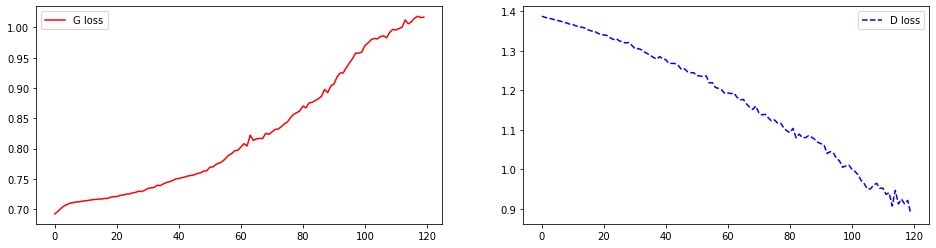

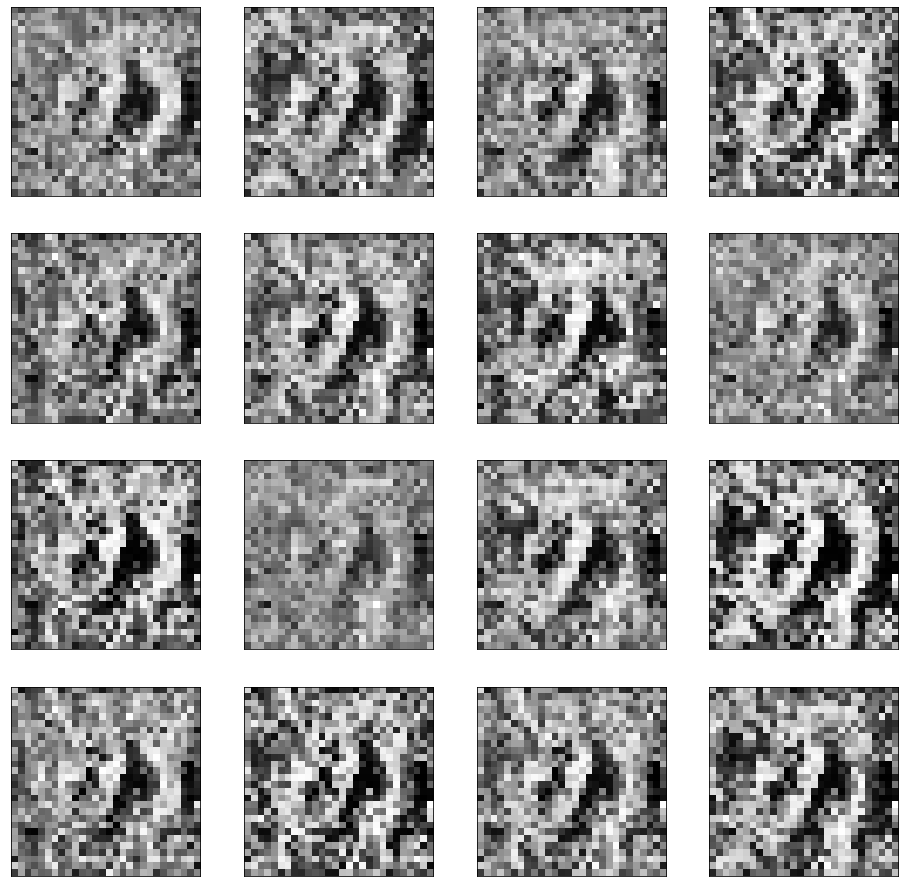

-------------------------------------------------------------------
[epoch 2], [training time 6.16]
-------------------------------------------------------------------


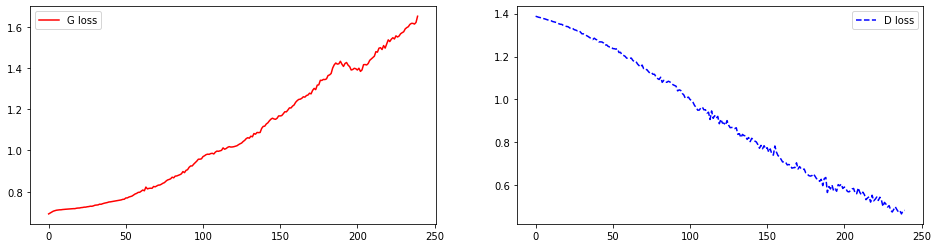

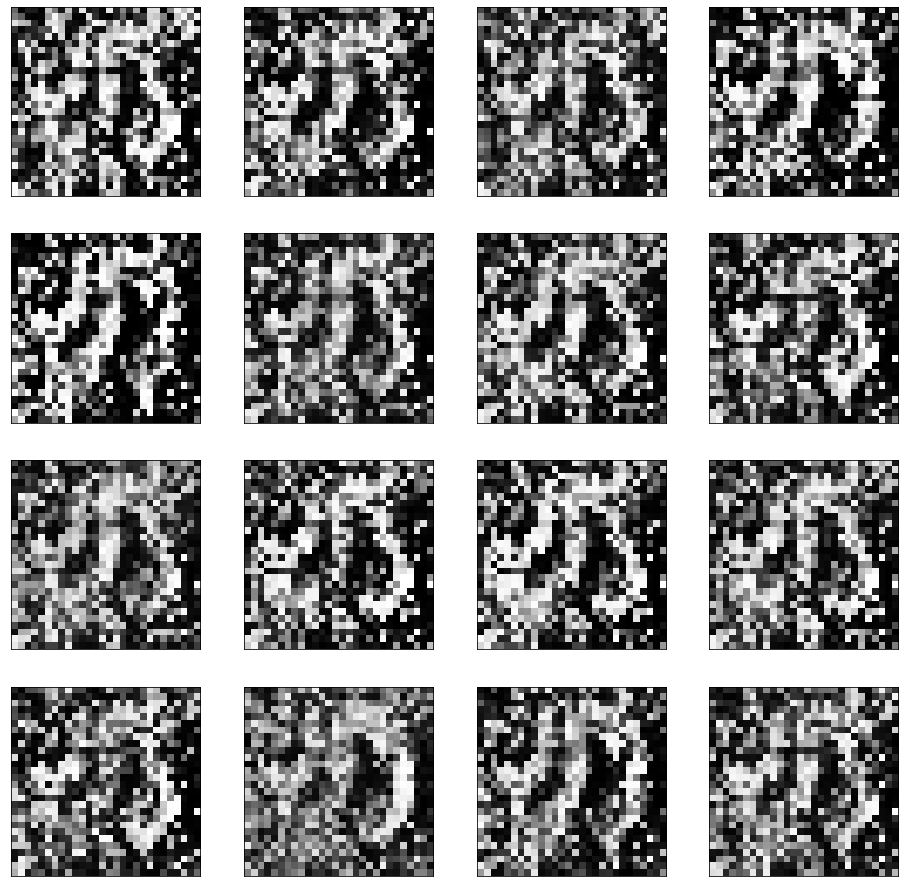

-------------------------------------------------------------------
[epoch 3], [training time 6.18]
-------------------------------------------------------------------


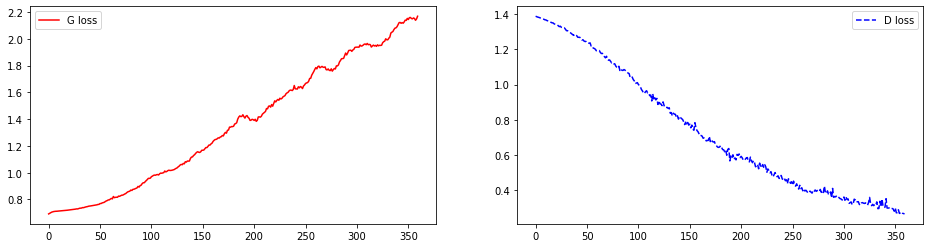

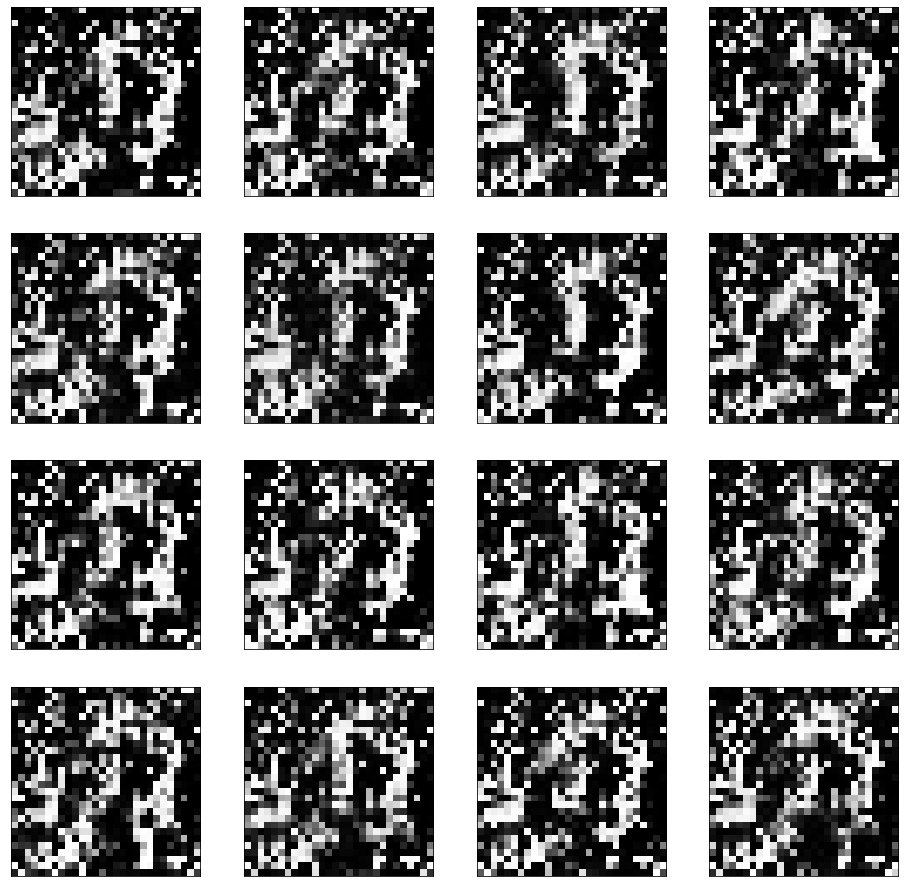

-------------------------------------------------------------------
[epoch 4], [training time 6.23]
-------------------------------------------------------------------


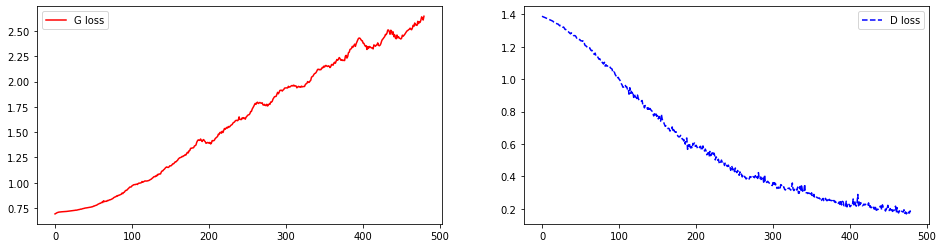

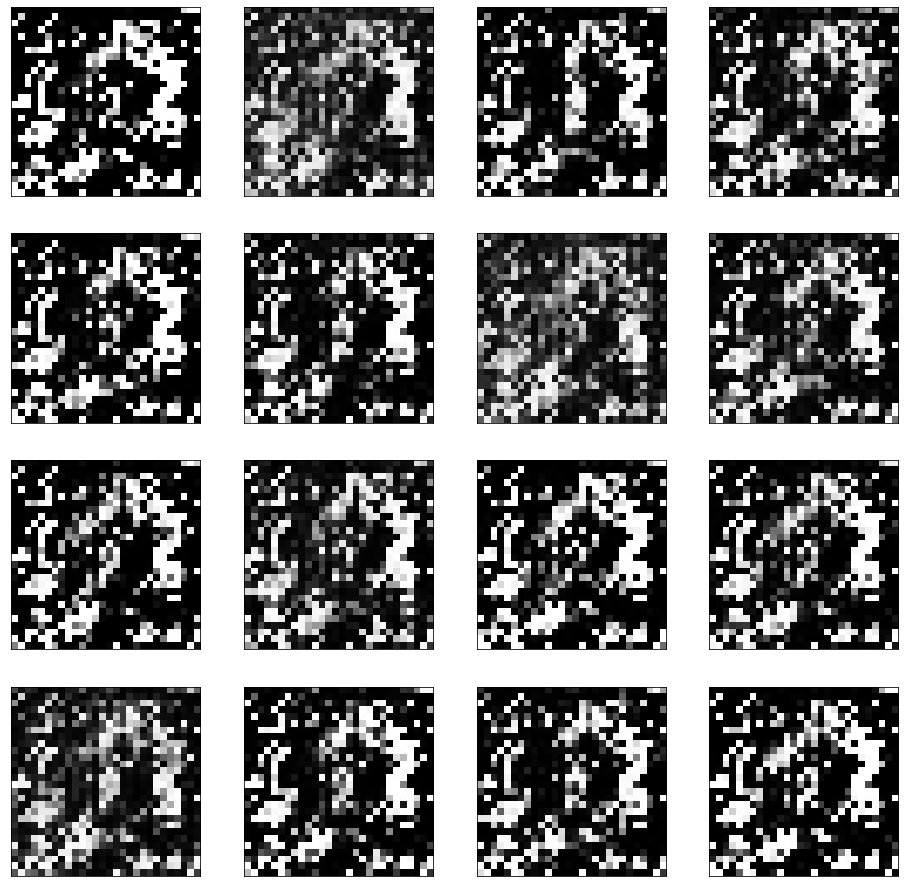

-------------------------------------------------------------------
[epoch 5], [training time 6.52]
-------------------------------------------------------------------


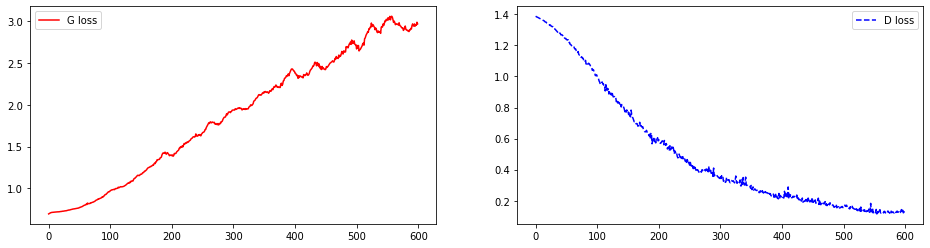

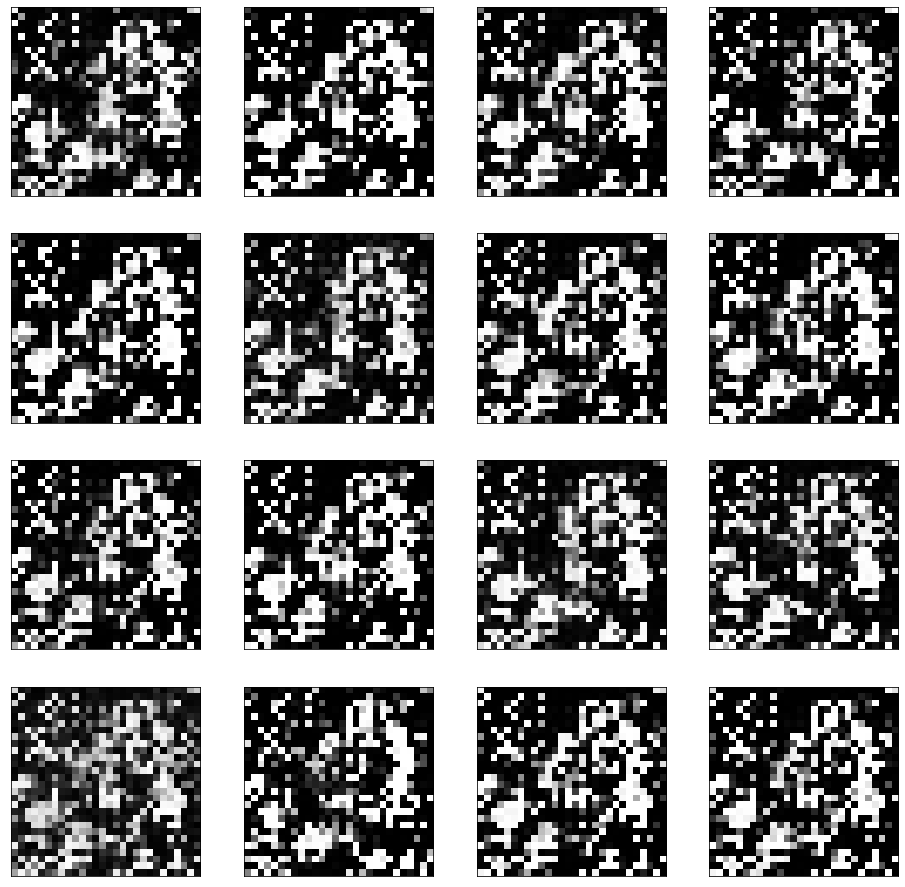

-------------------------------------------------------------------
[epoch 6], [training time 6.17]
-------------------------------------------------------------------


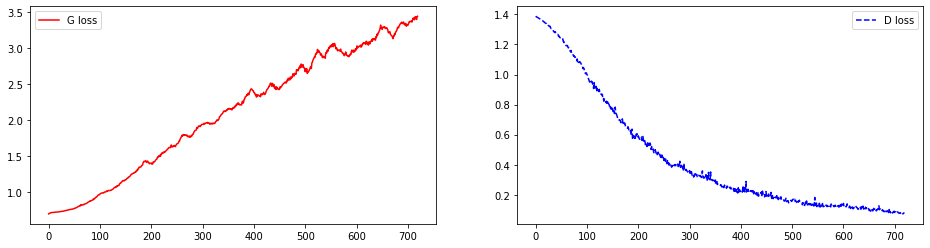

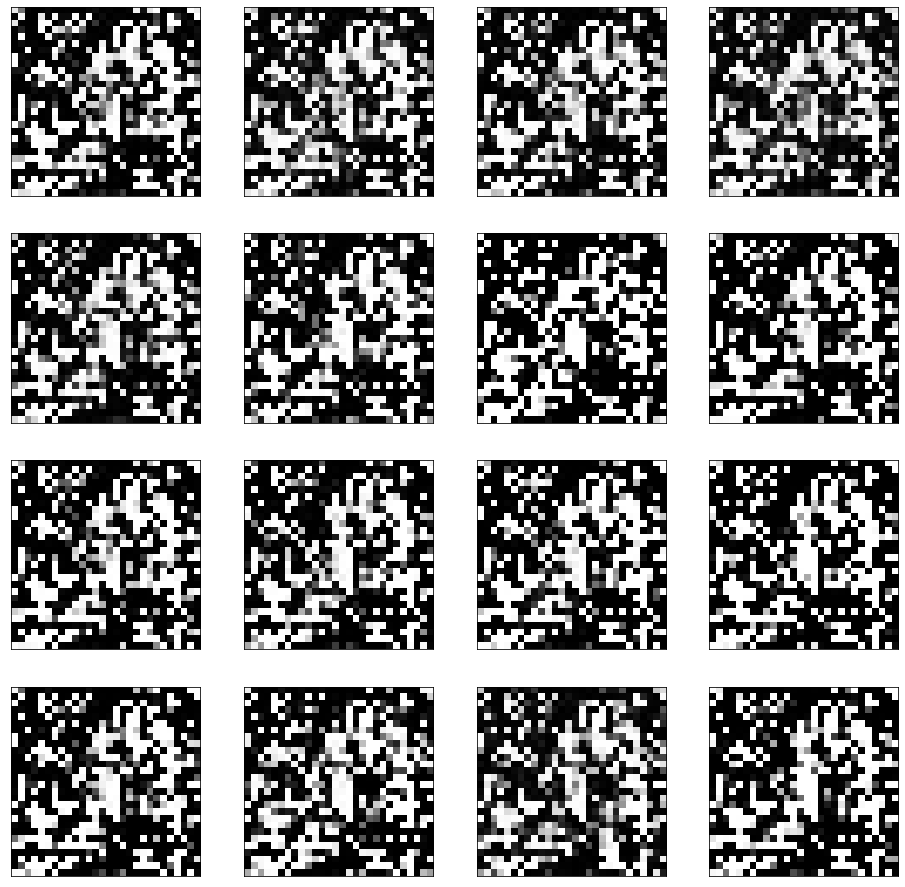

-------------------------------------------------------------------
[epoch 7], [training time 6.24]
-------------------------------------------------------------------


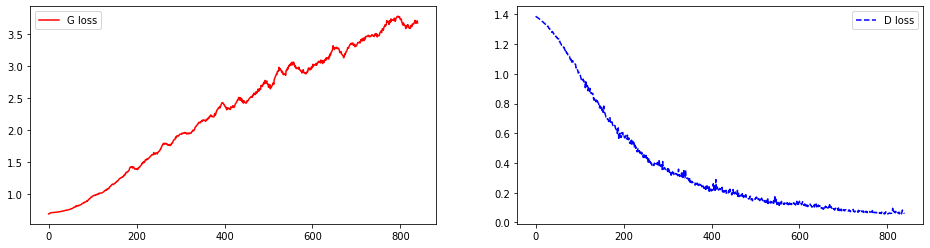

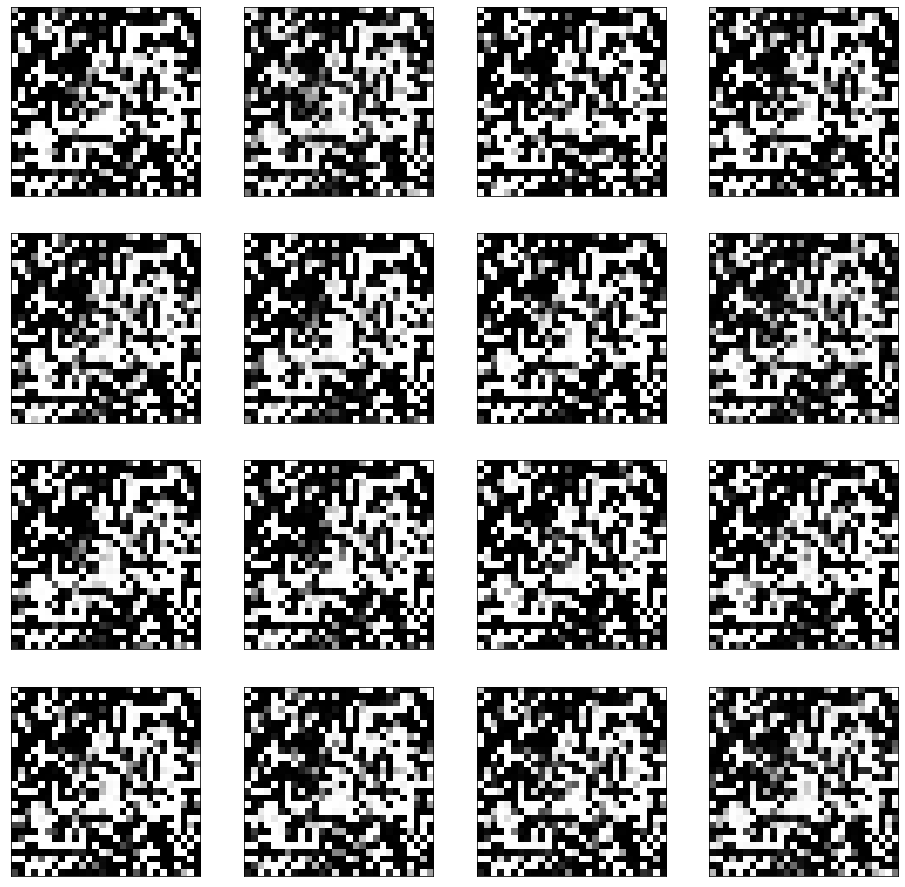

-------------------------------------------------------------------
[epoch 8], [training time 6.17]
-------------------------------------------------------------------


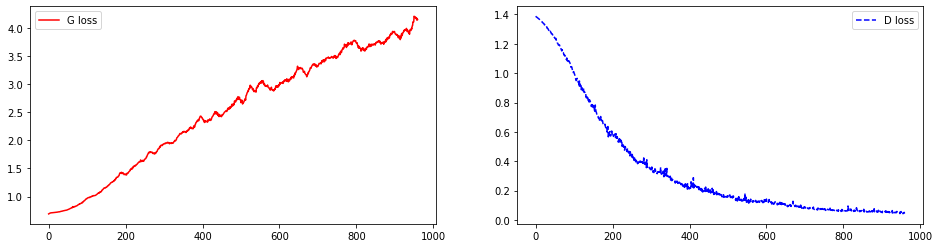

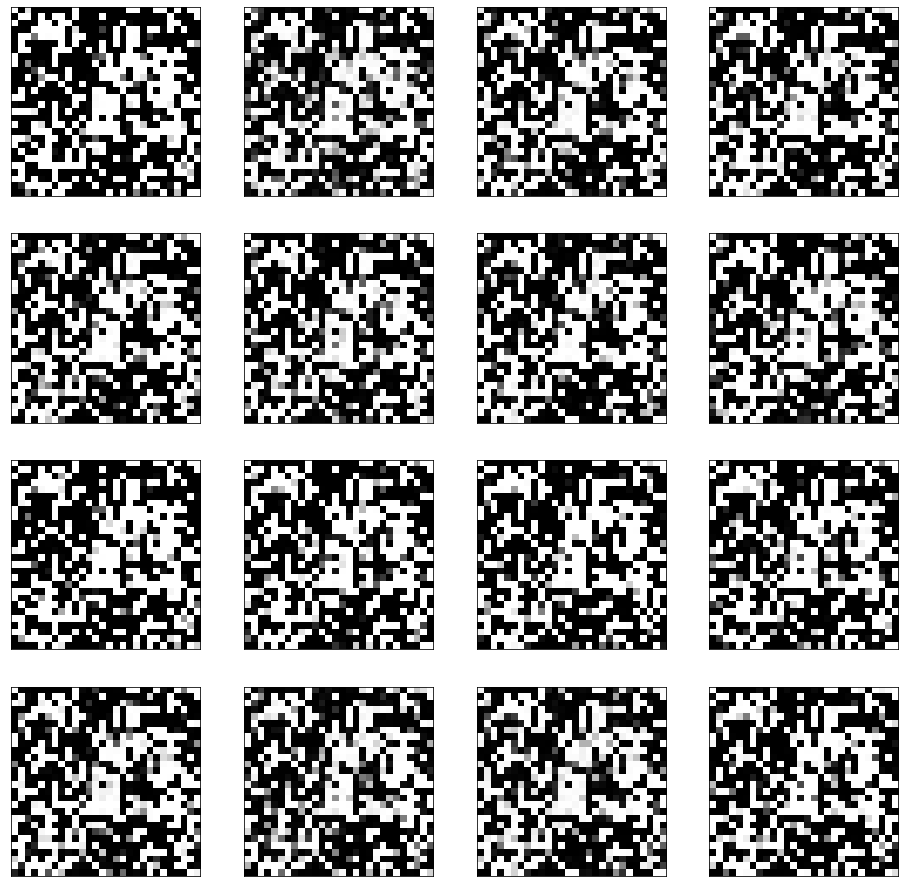

-------------------------------------------------------------------
[epoch 9], [training time 6.14]
-------------------------------------------------------------------


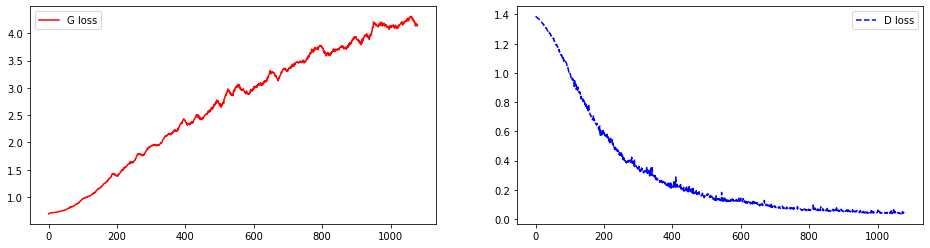

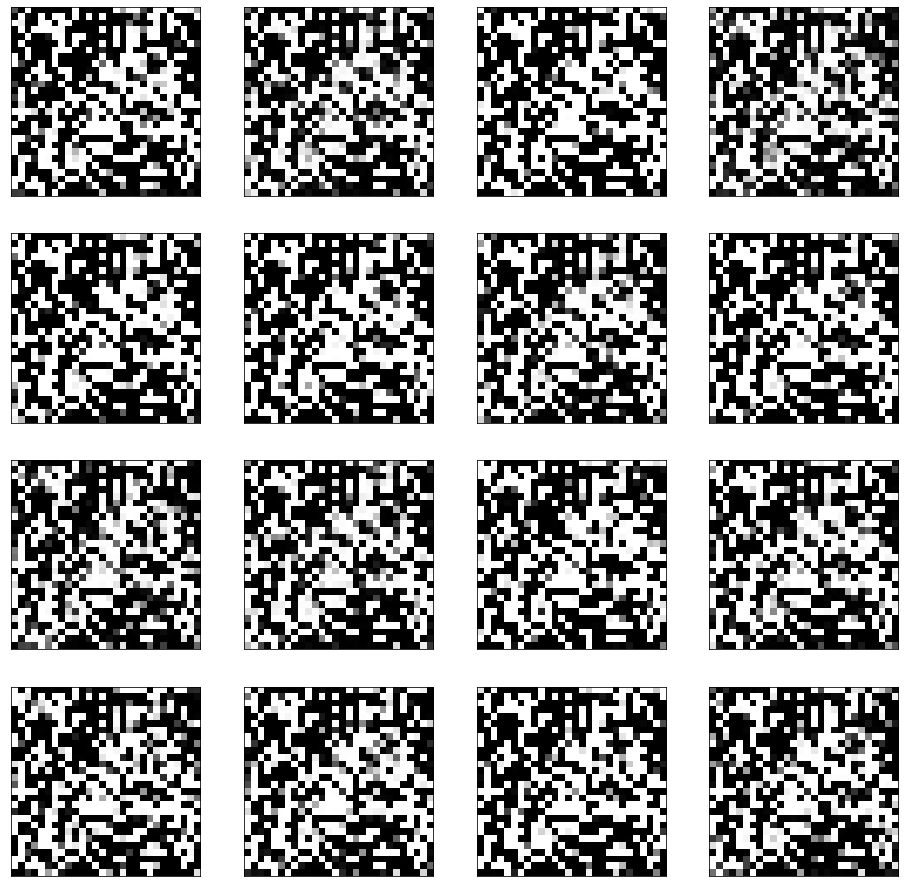

-------------------------------------------------------------------
[epoch 10], [training time 6.51]
-------------------------------------------------------------------


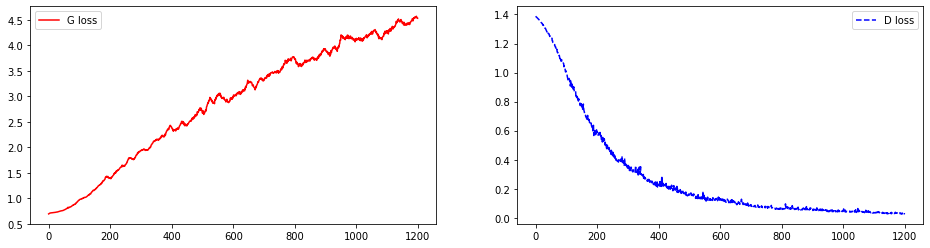

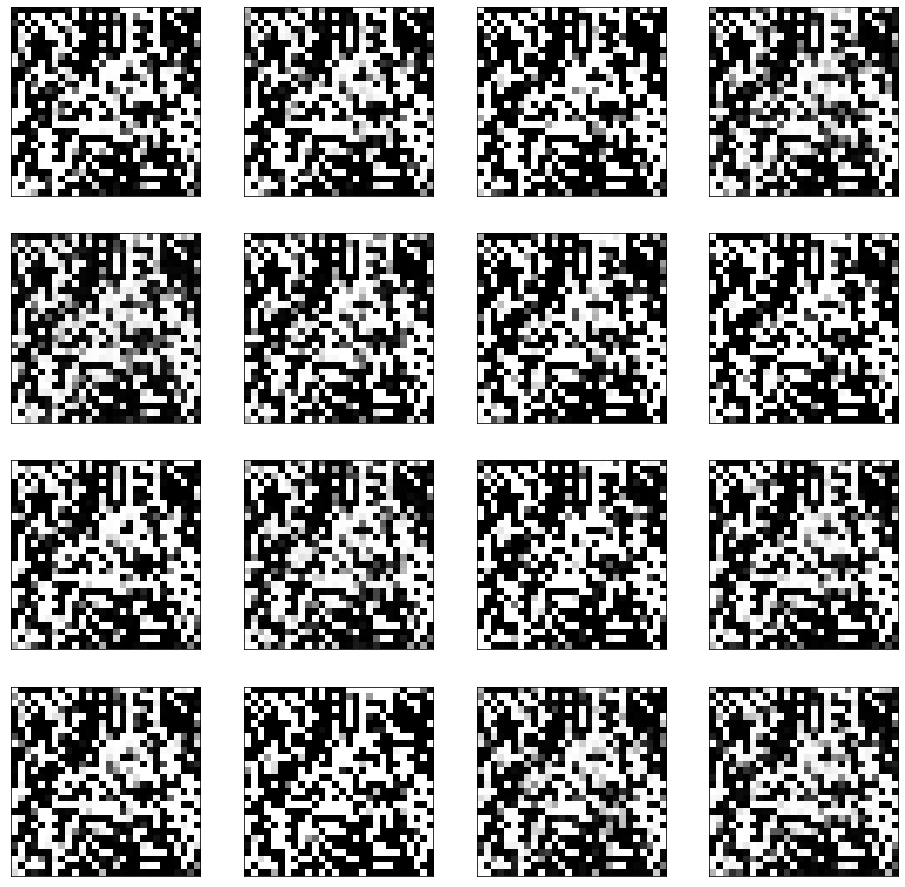

-------------------------------------------------------------------
[epoch 11], [training time 6.28]
-------------------------------------------------------------------


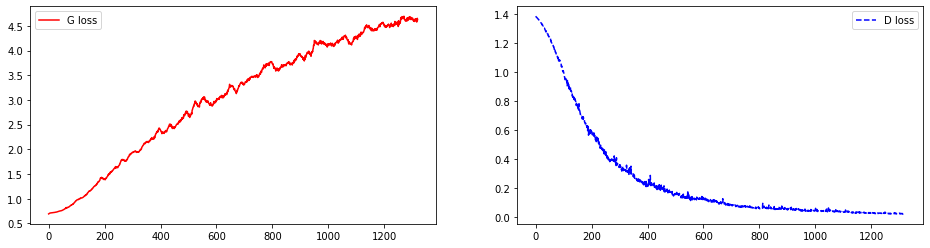

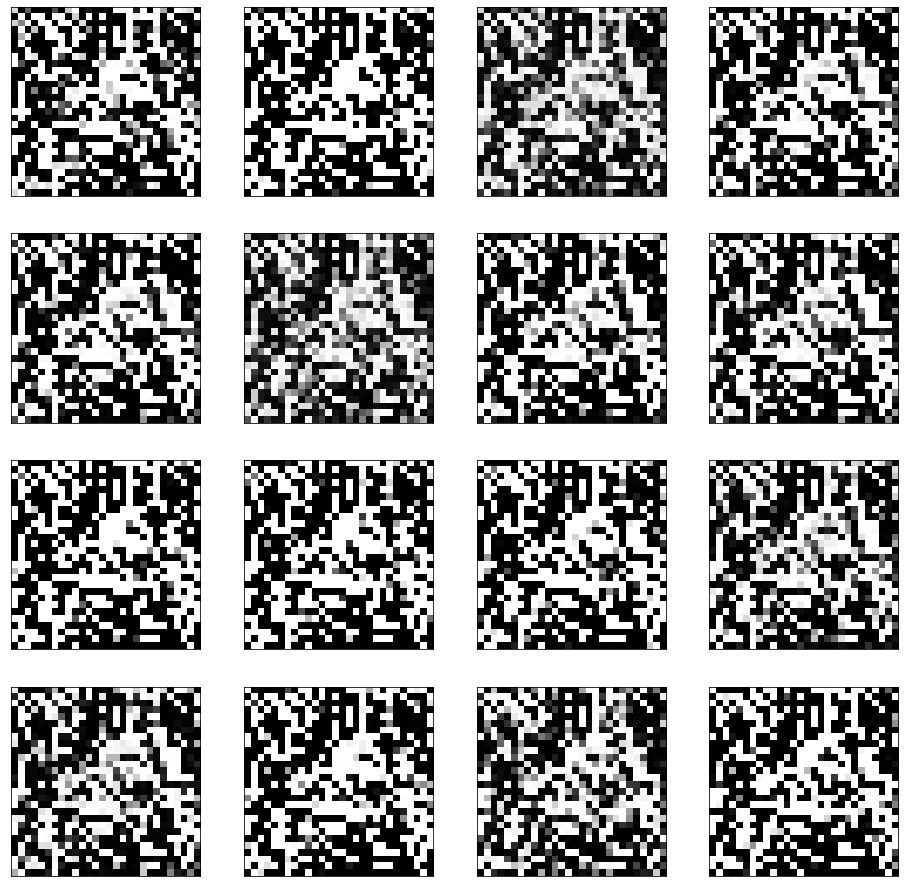

-------------------------------------------------------------------
[epoch 12], [training time 6.87]
-------------------------------------------------------------------


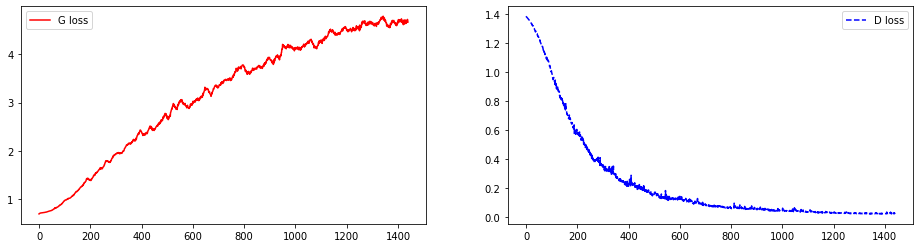

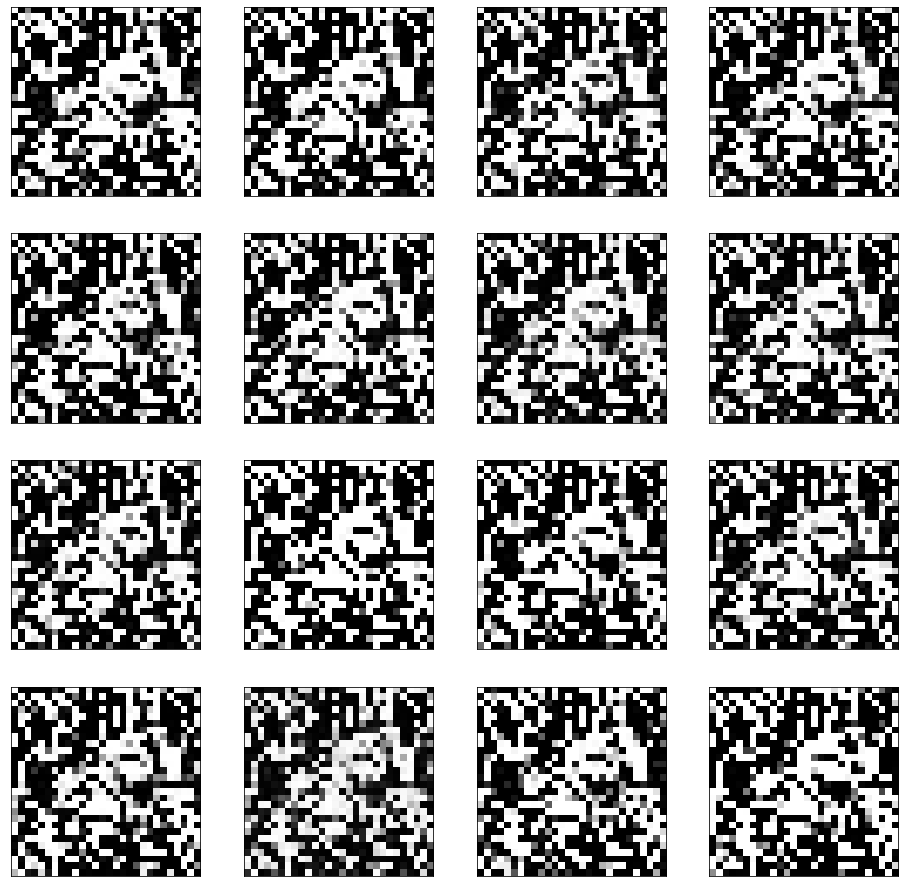

-------------------------------------------------------------------
[epoch 13], [training time 6.13]
-------------------------------------------------------------------


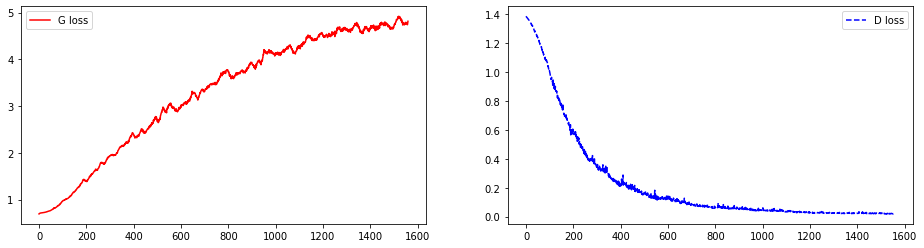

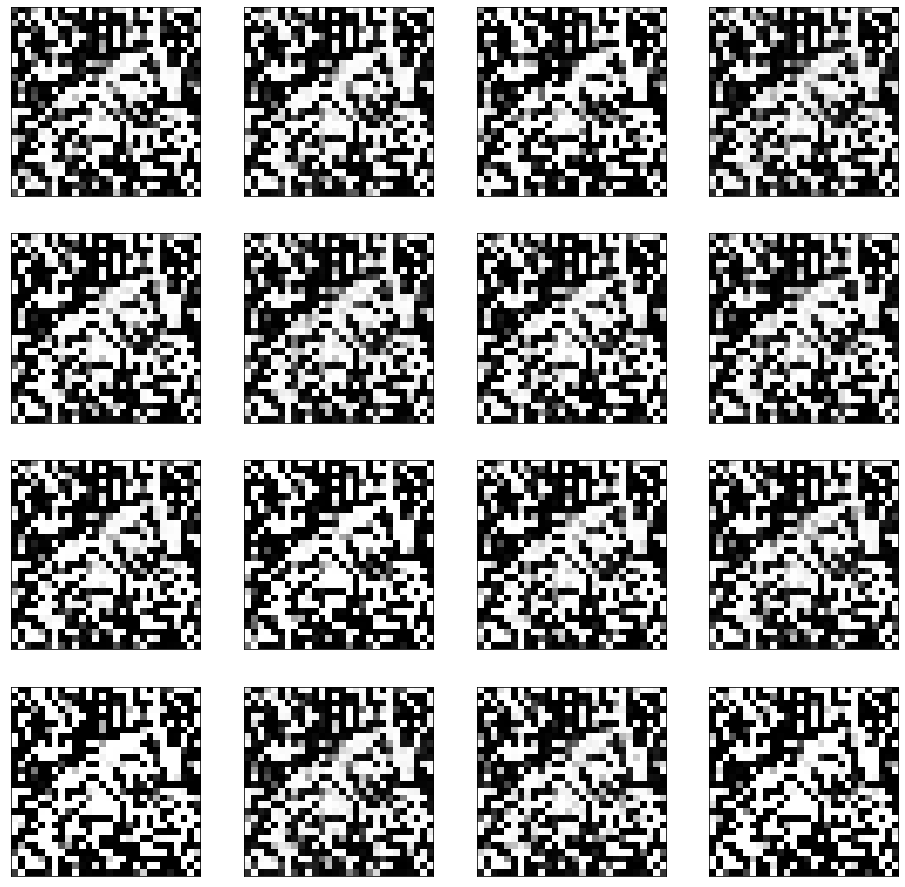

-------------------------------------------------------------------
[epoch 14], [training time 6.96]
-------------------------------------------------------------------


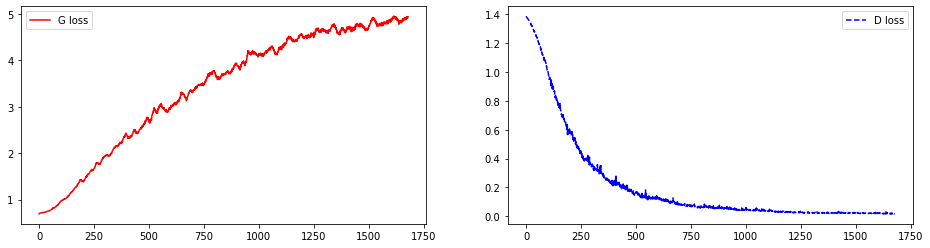

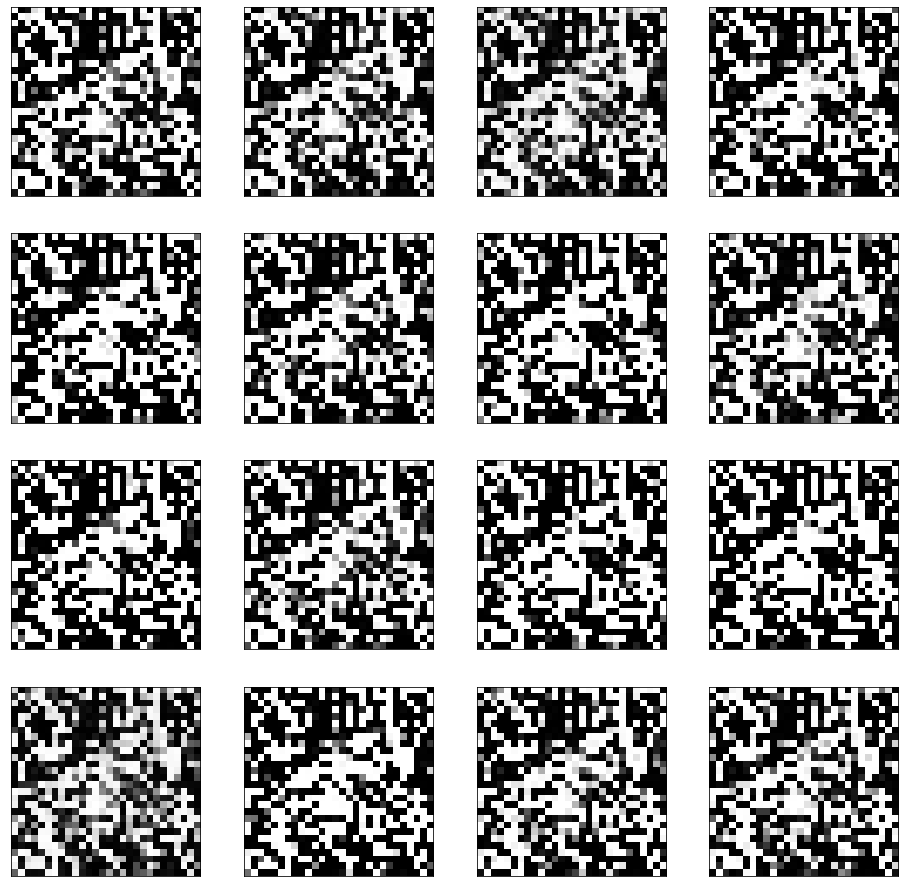

-------------------------------------------------------------------
[epoch 15], [training time 6.42]
-------------------------------------------------------------------


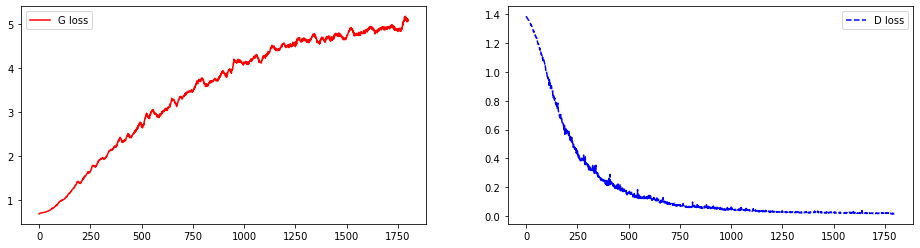

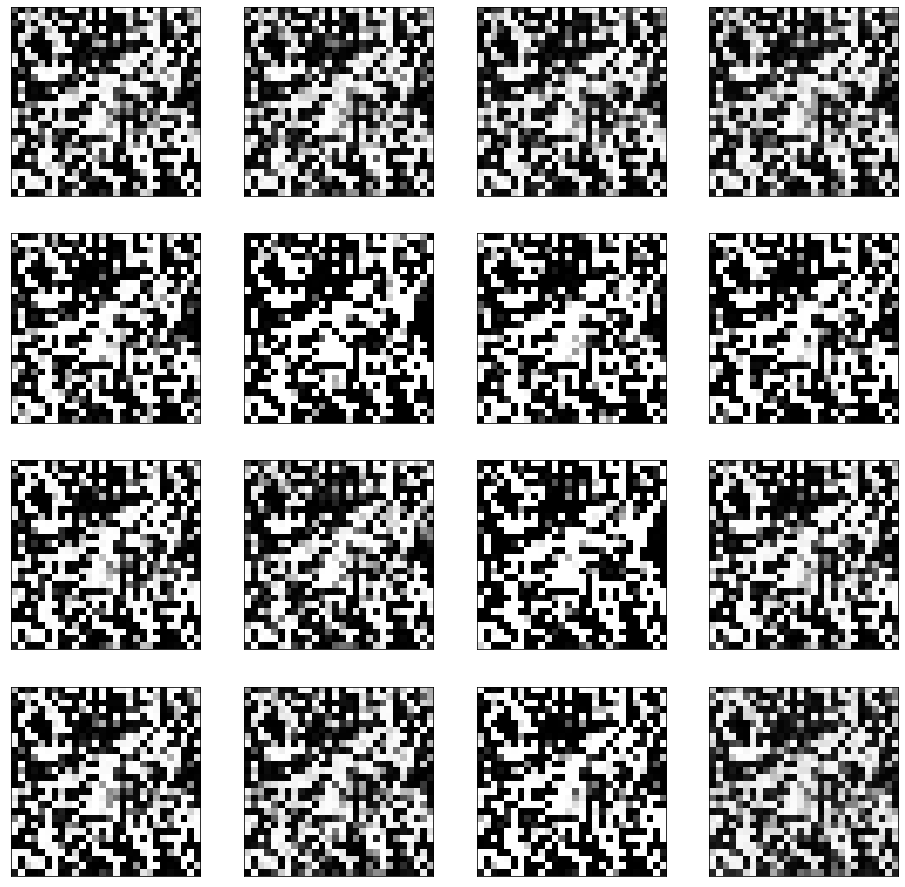

-------------------------------------------------------------------
[epoch 16], [training time 7.08]
-------------------------------------------------------------------


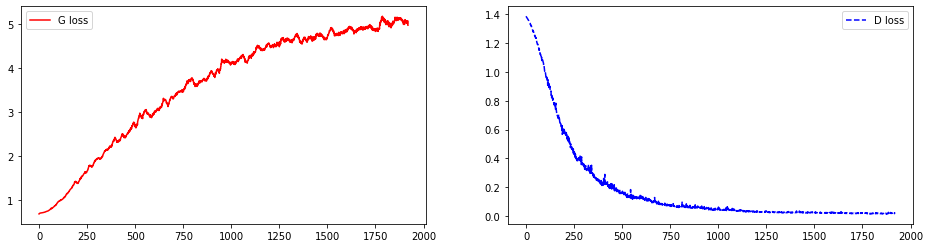

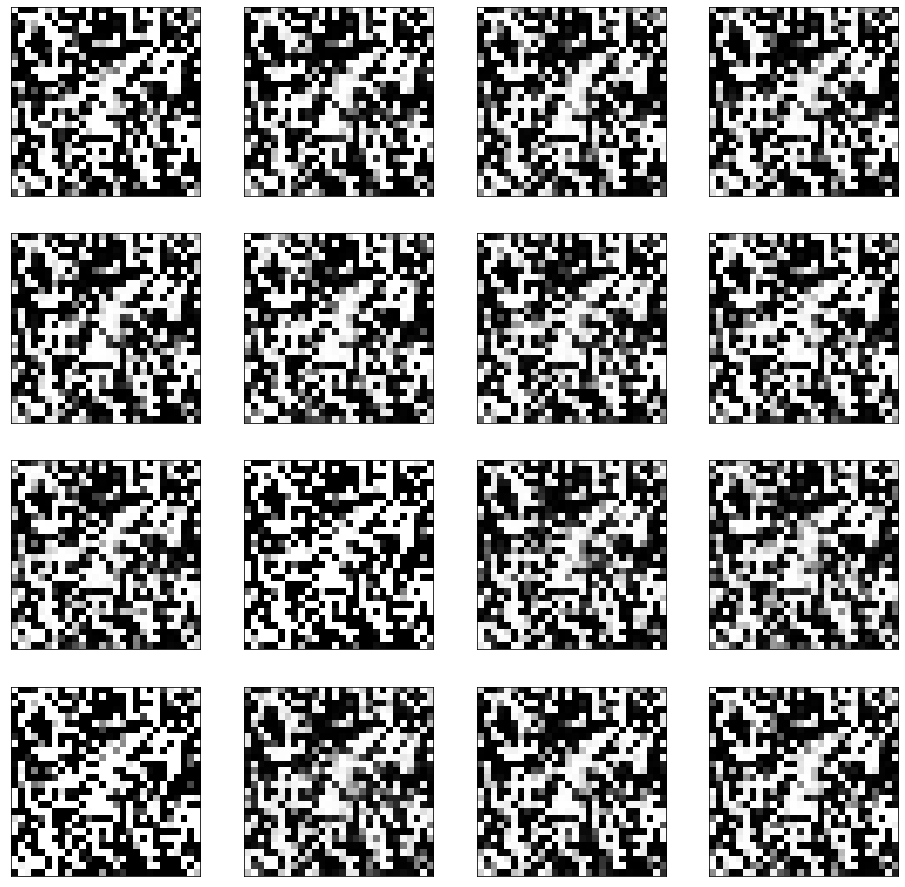

-------------------------------------------------------------------
[epoch 17], [training time 6.31]
-------------------------------------------------------------------


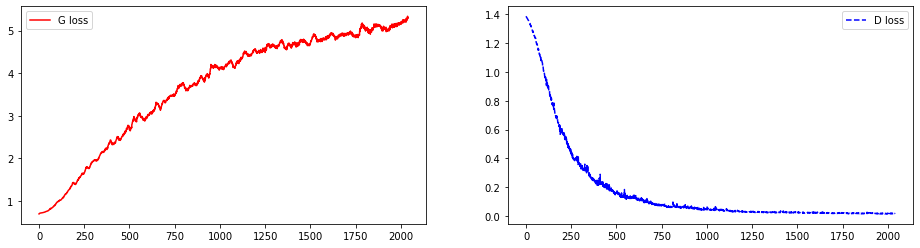

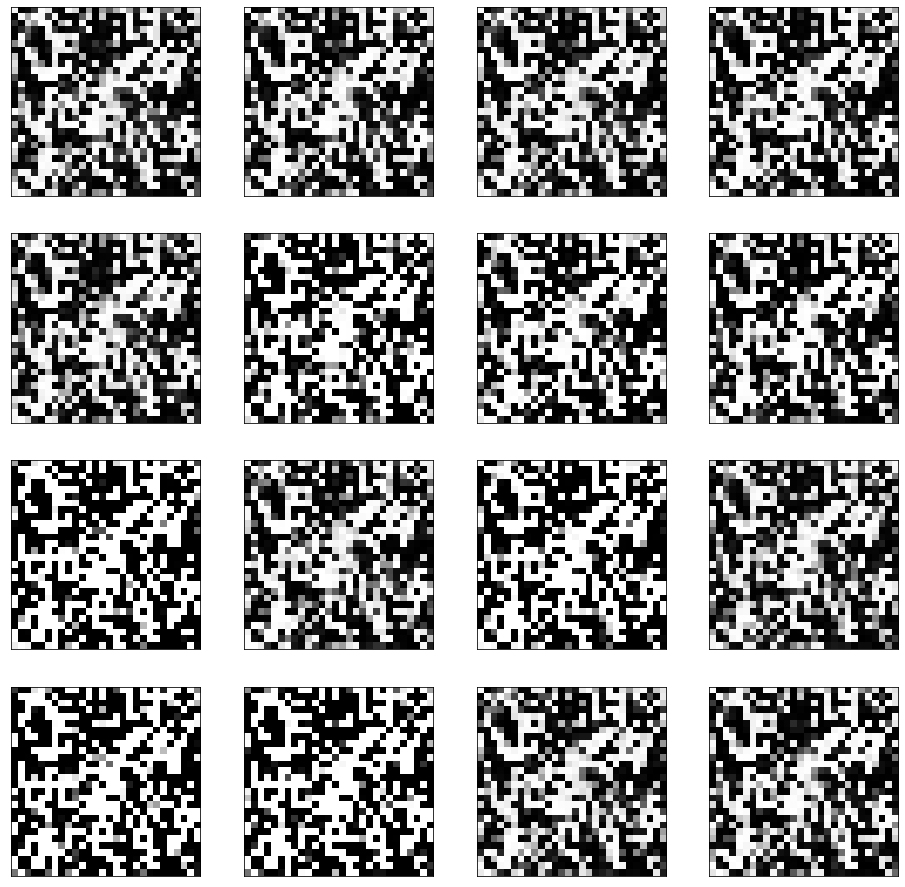

-------------------------------------------------------------------
[epoch 18], [training time 6.88]
-------------------------------------------------------------------


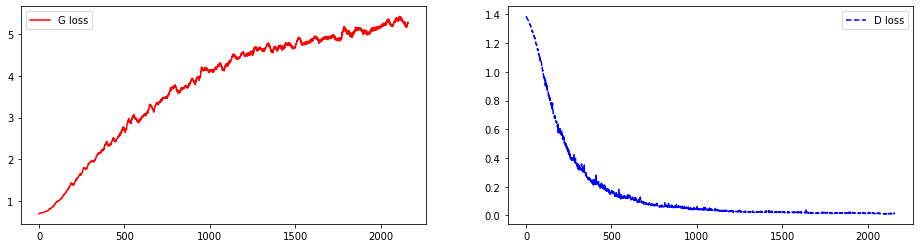

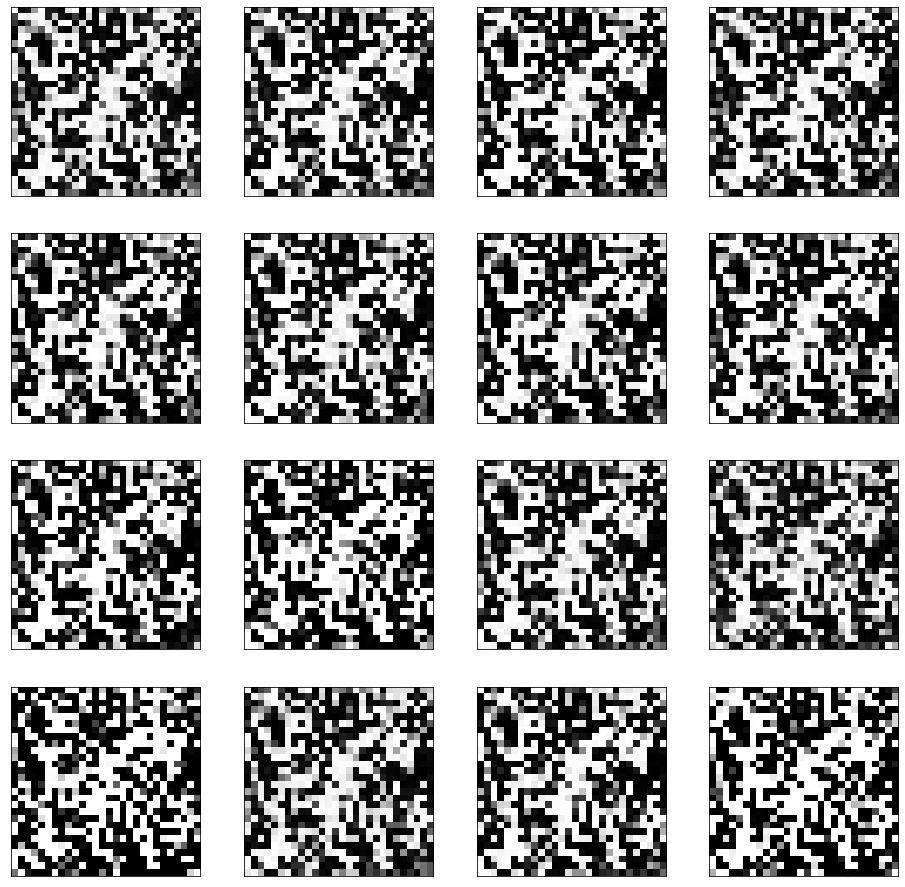

-------------------------------------------------------------------
[epoch 19], [training time 6.15]
-------------------------------------------------------------------


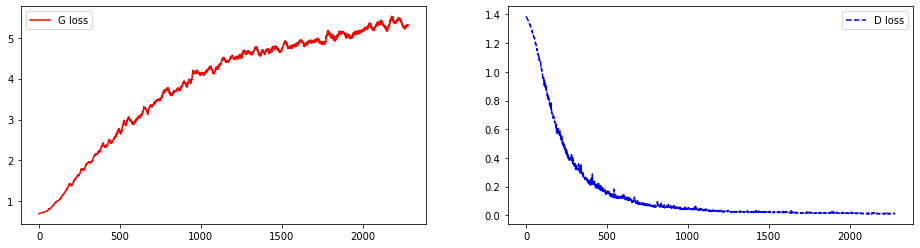

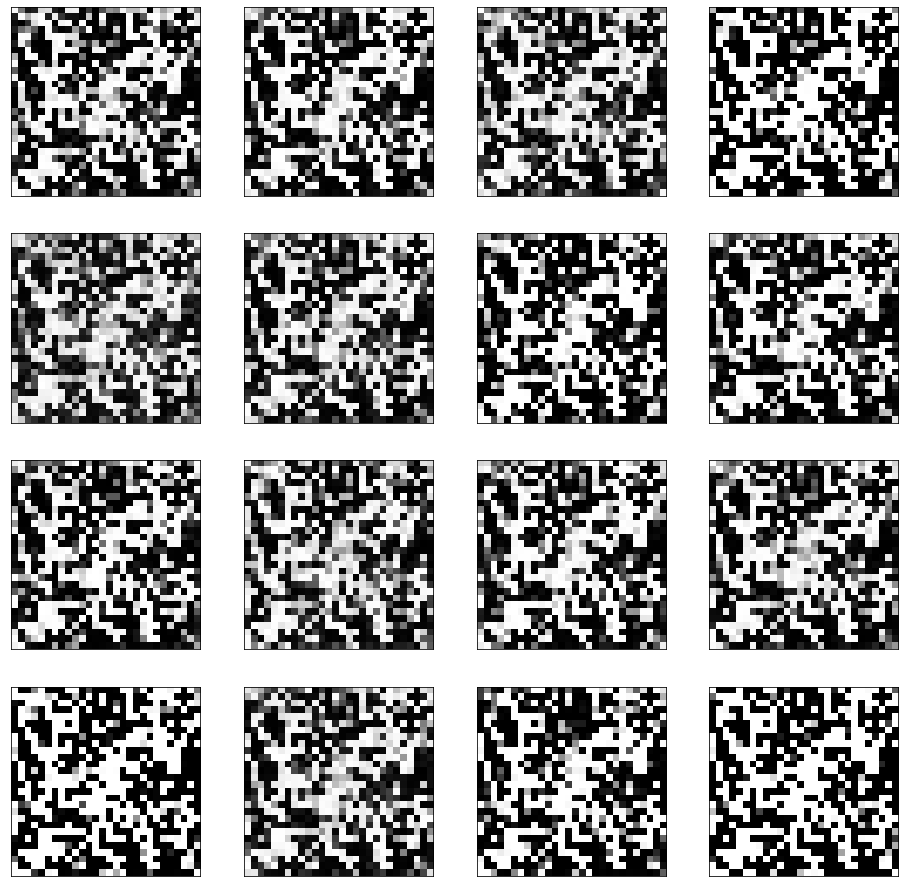

-------------------------------------------------------------------
[epoch 20], [training time 6.47]
-------------------------------------------------------------------


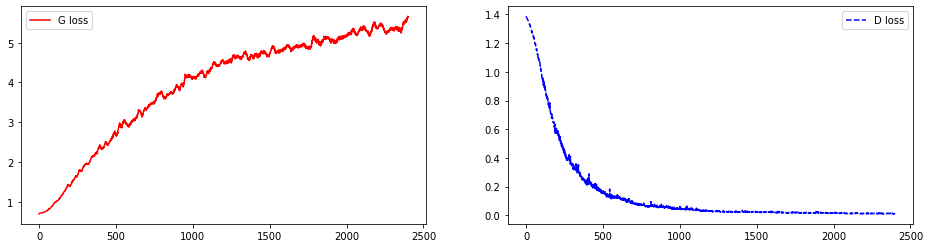

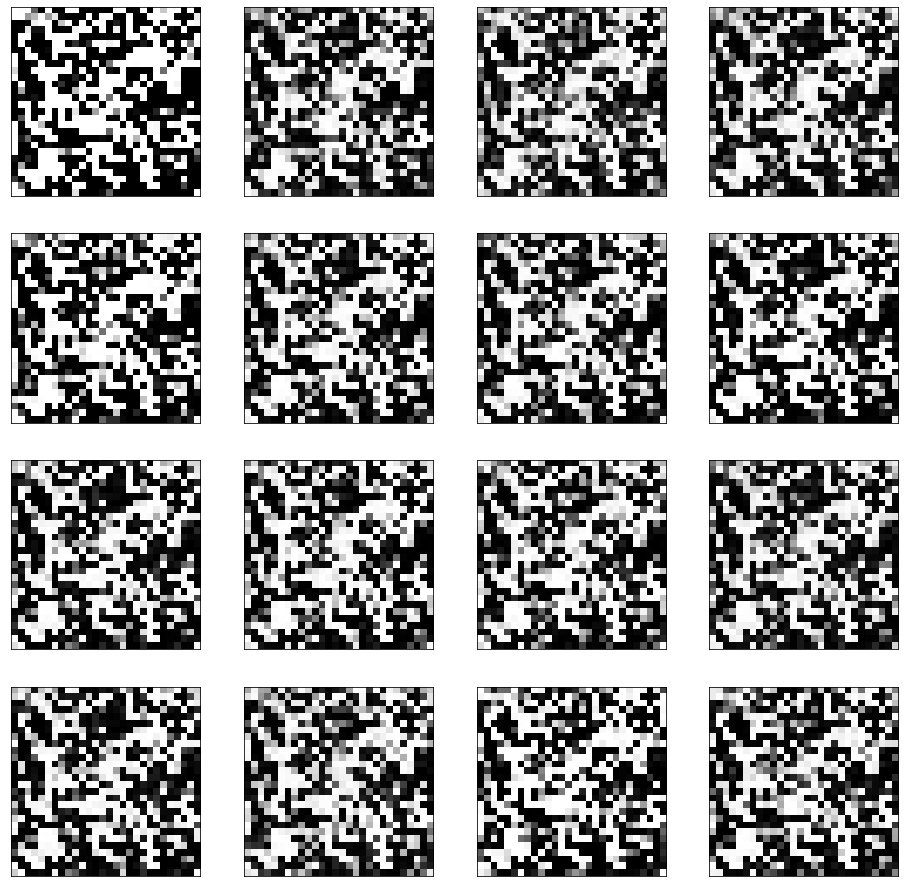

-------------------------------------------------------------------
[epoch 21], [training time 6.38]
-------------------------------------------------------------------


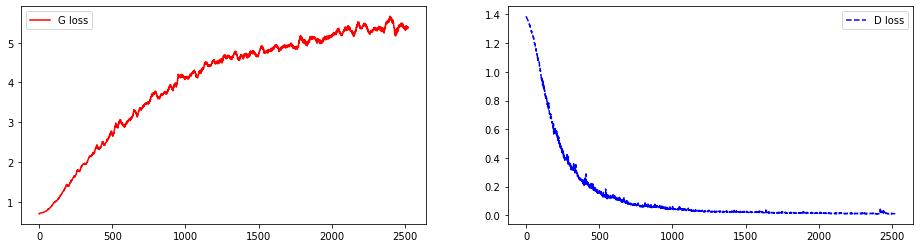

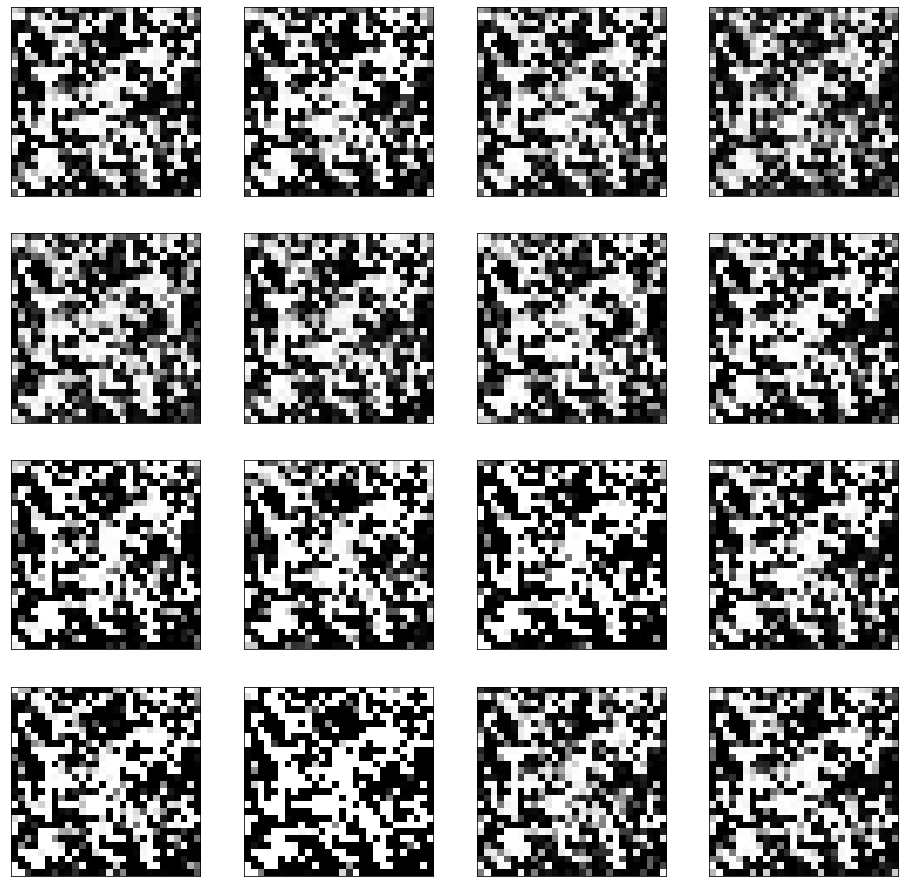

-------------------------------------------------------------------
[epoch 22], [training time 6.17]
-------------------------------------------------------------------


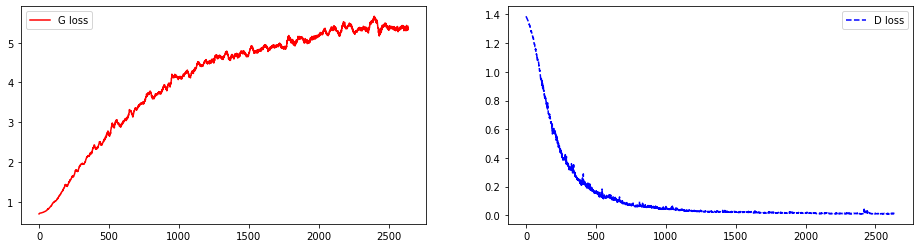

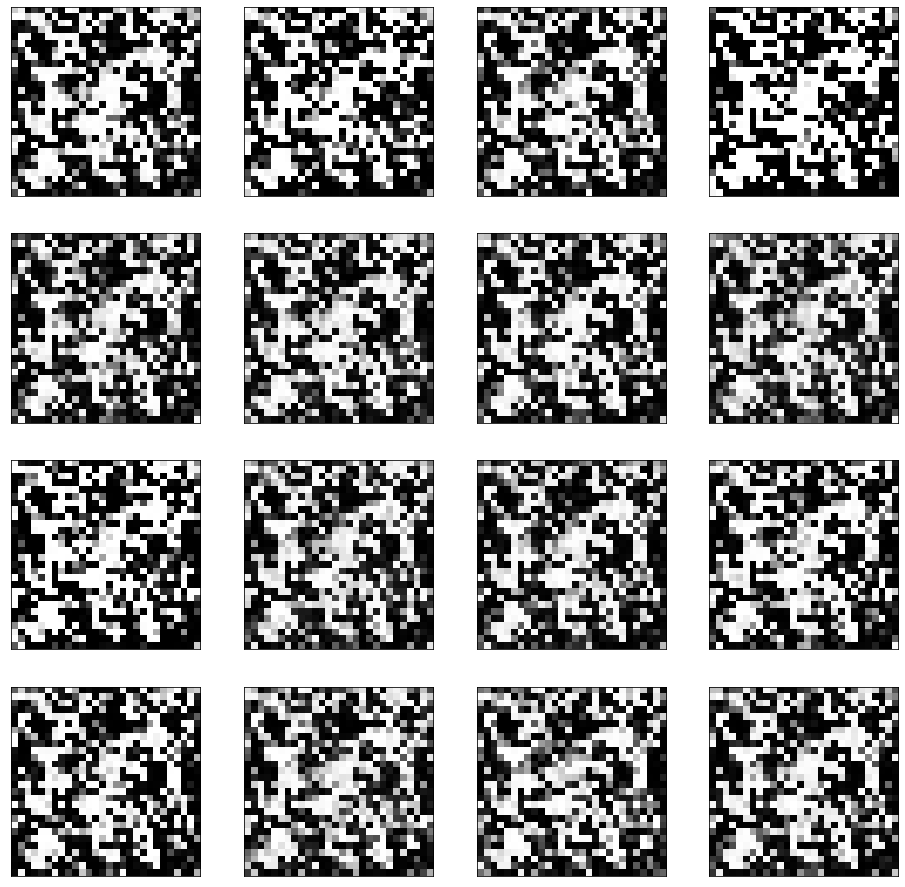

-------------------------------------------------------------------
[epoch 23], [training time 5.99]
-------------------------------------------------------------------


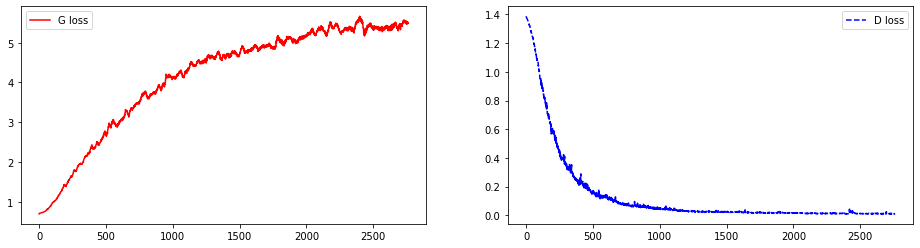

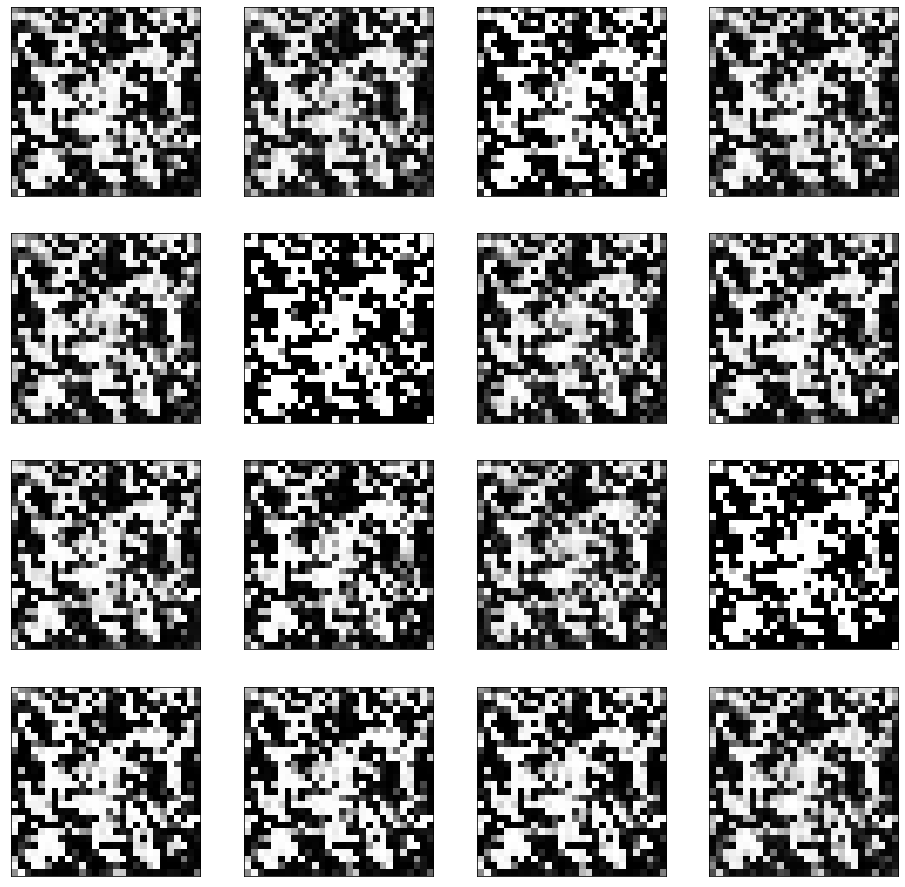

-------------------------------------------------------------------
[epoch 24], [training time 6.22]
-------------------------------------------------------------------


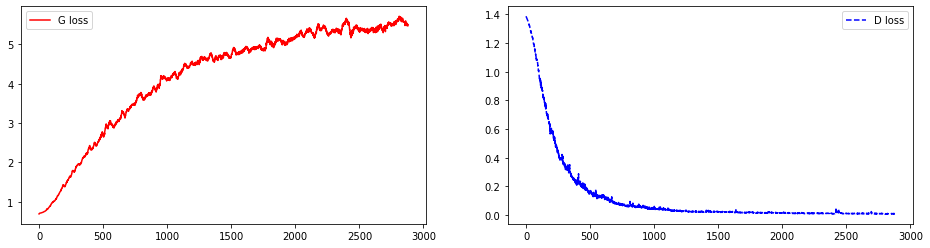

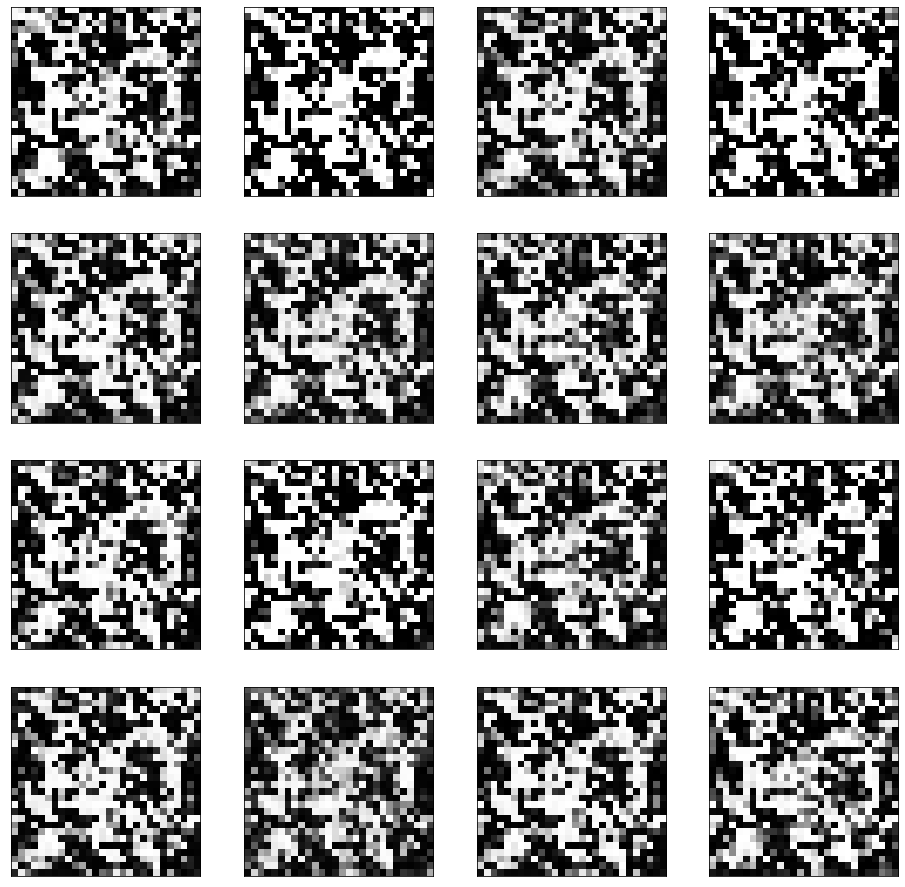

-------------------------------------------------------------------
[epoch 25], [training time 6.27]
-------------------------------------------------------------------


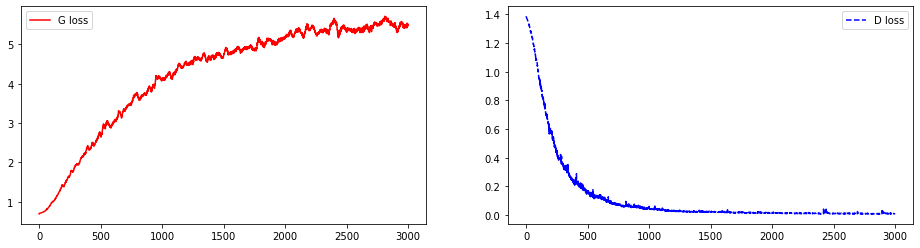

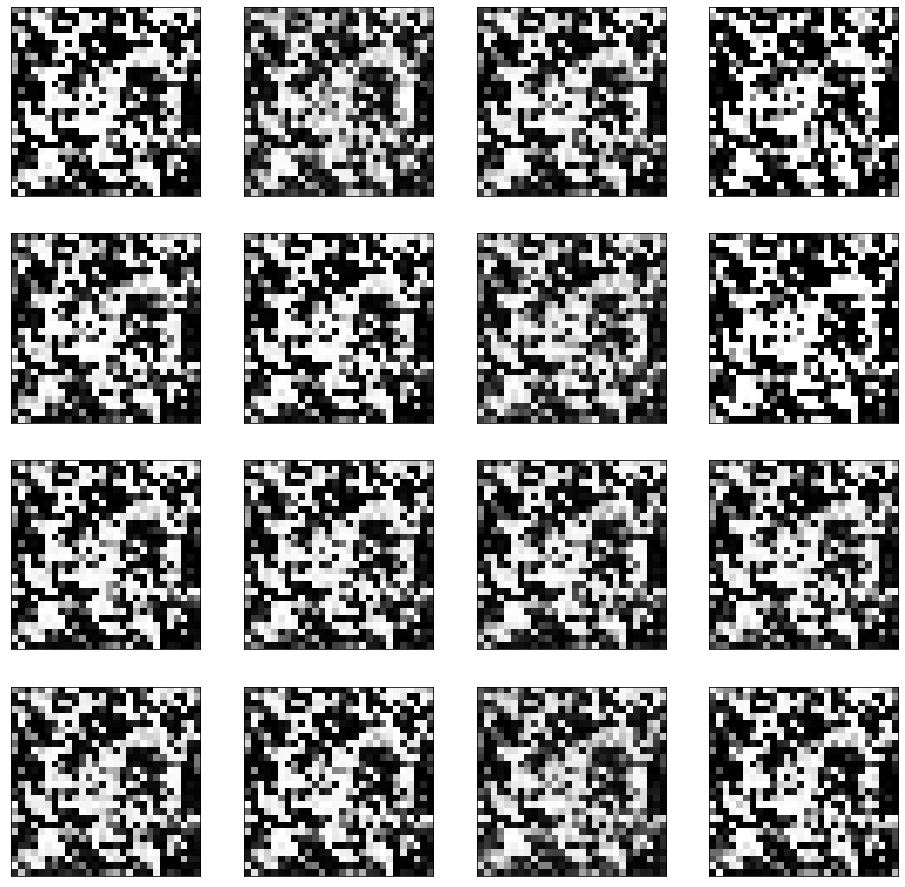

-------------------------------------------------------------------
[epoch 26], [training time 7.00]
-------------------------------------------------------------------


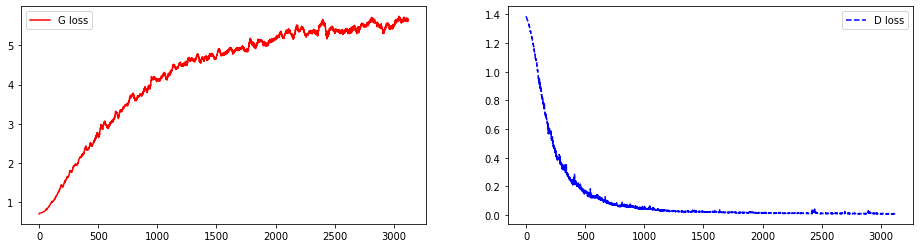

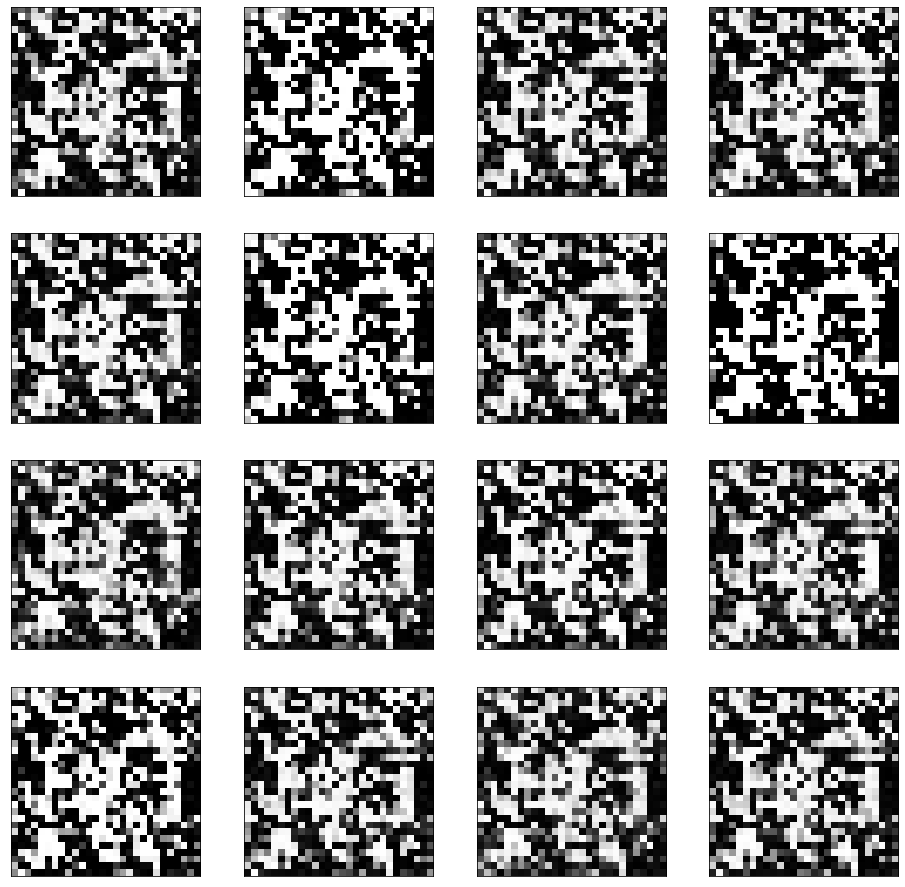

-------------------------------------------------------------------
[epoch 27], [training time 6.21]
-------------------------------------------------------------------


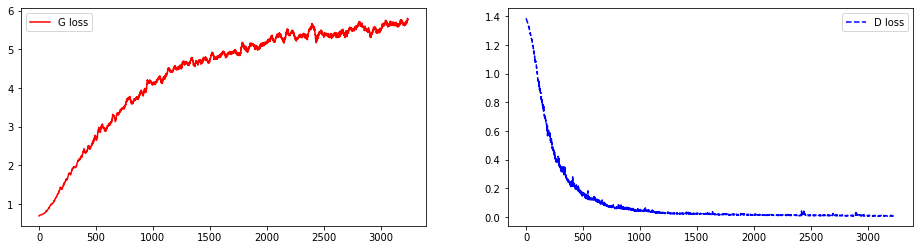

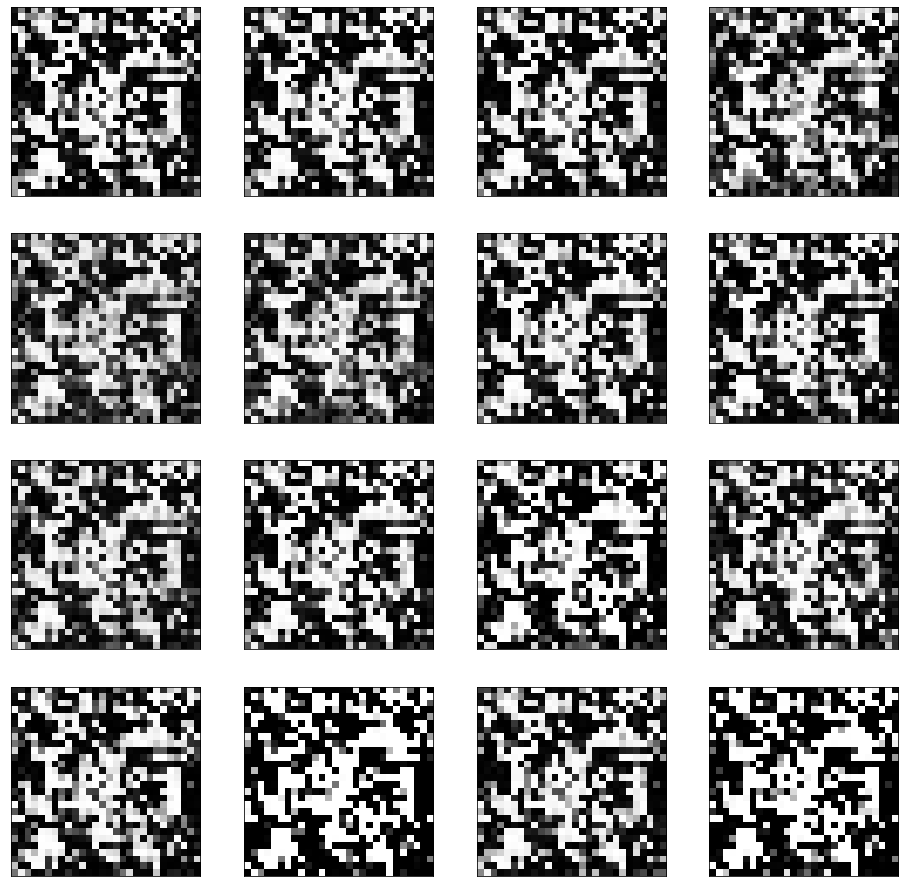

-------------------------------------------------------------------
[epoch 28], [training time 7.16]
-------------------------------------------------------------------


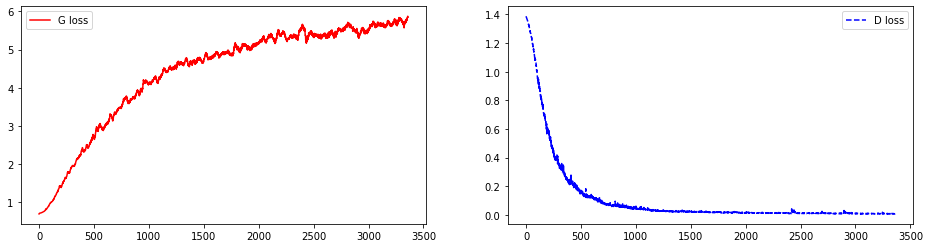

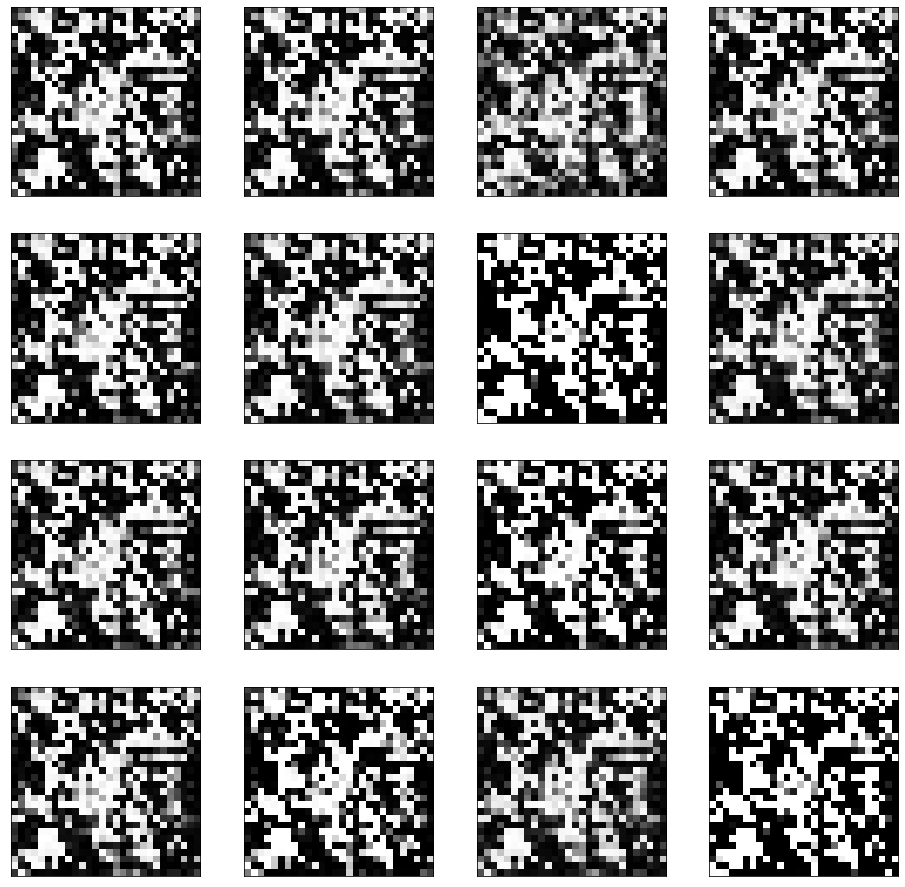

-------------------------------------------------------------------
[epoch 29], [training time 6.38]
-------------------------------------------------------------------


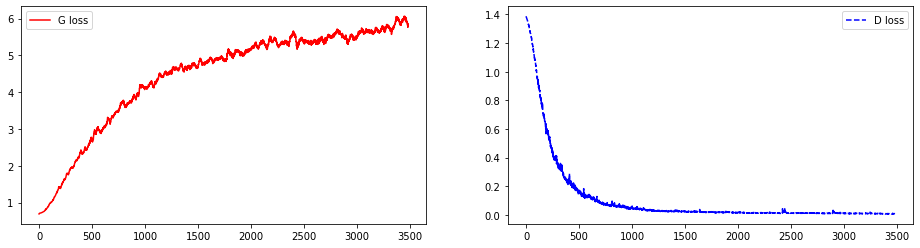

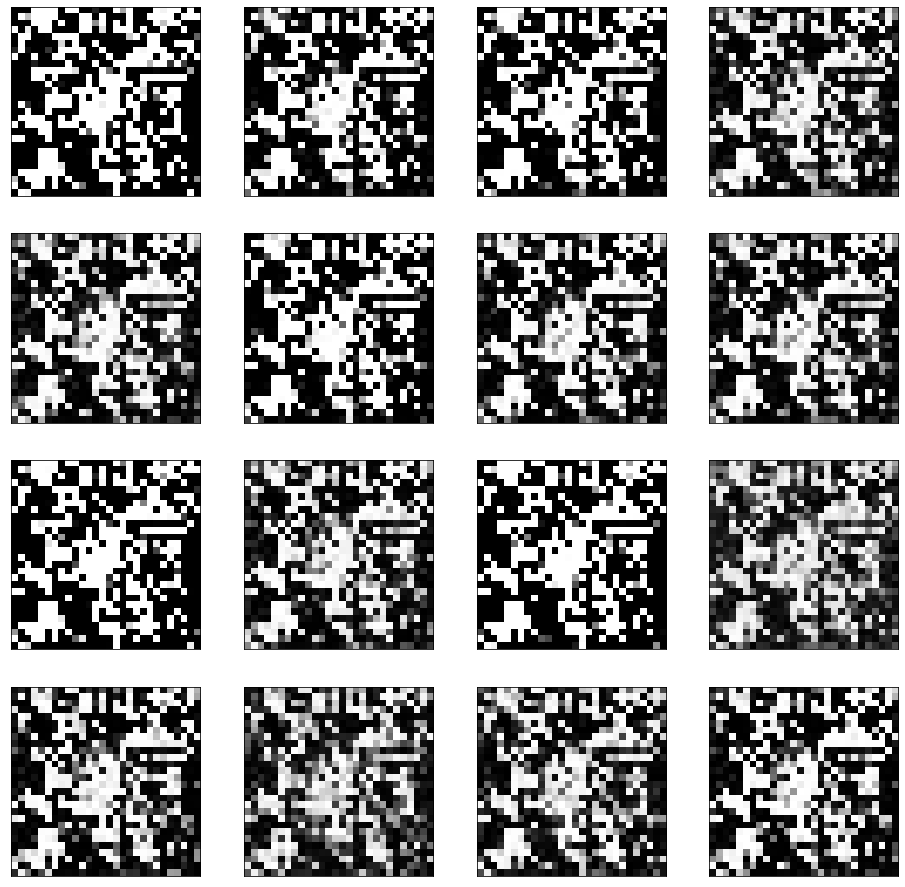

-------------------------------------------------------------------
[epoch 30], [training time 7.00]
-------------------------------------------------------------------


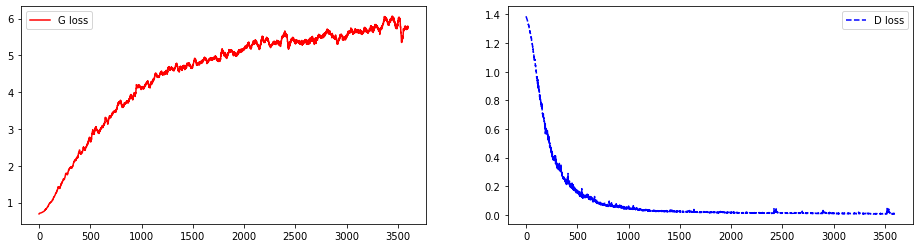

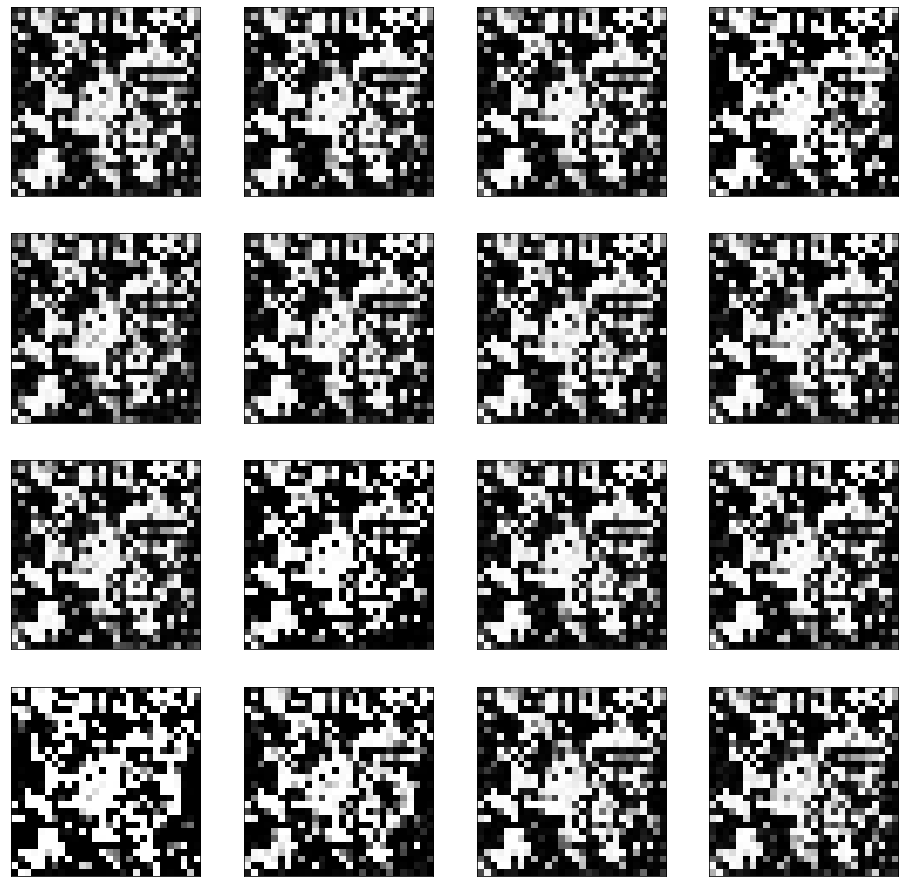

-------------------------------------------------------------------
[epoch 31], [training time 6.16]
-------------------------------------------------------------------


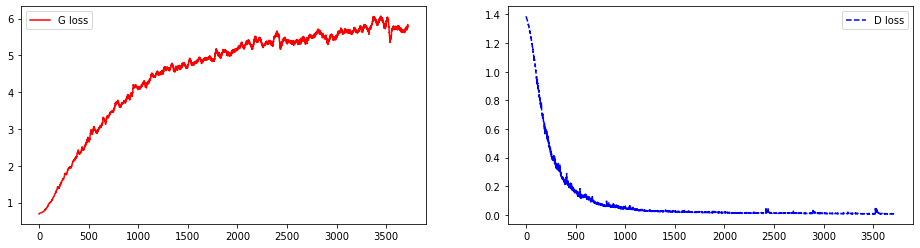

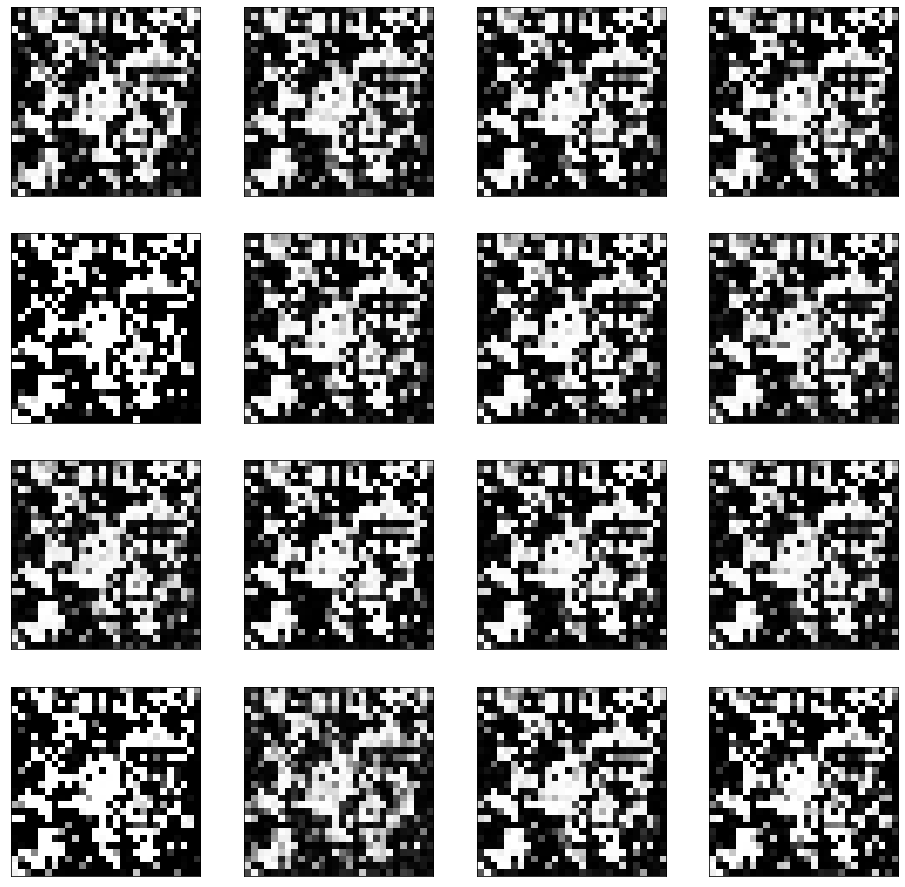

-------------------------------------------------------------------
[epoch 32], [training time 6.88]
-------------------------------------------------------------------


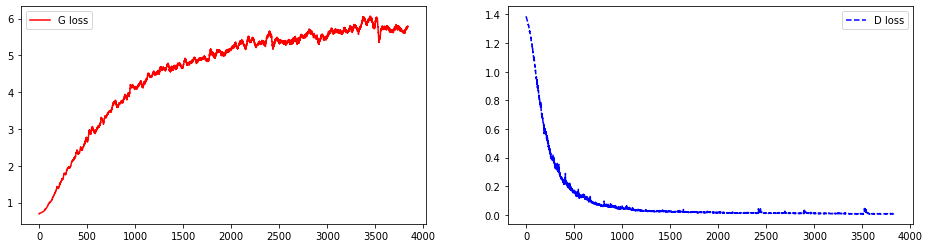

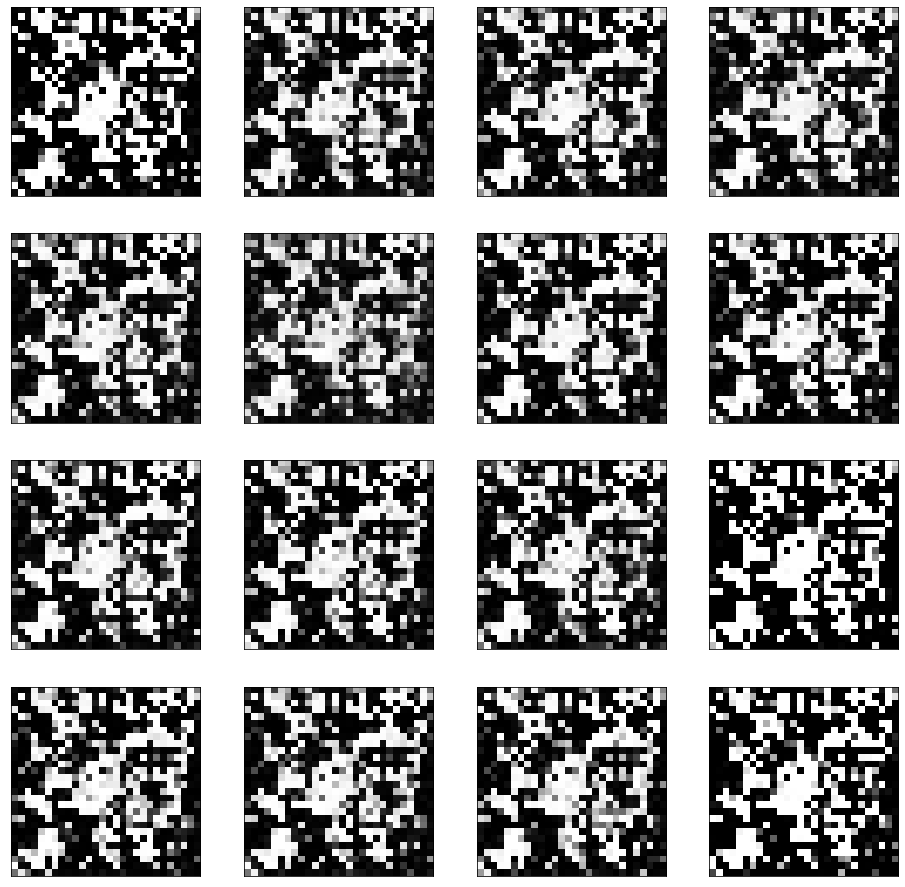

-------------------------------------------------------------------
[epoch 33], [training time 6.35]
-------------------------------------------------------------------


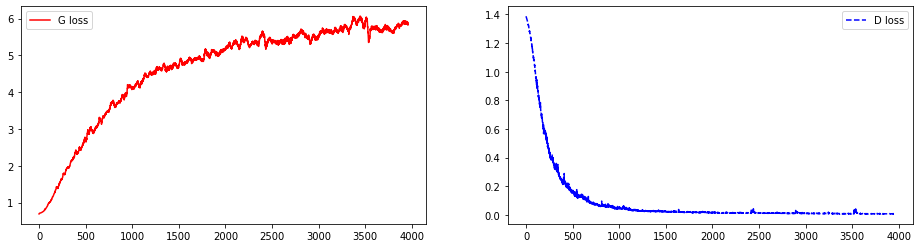

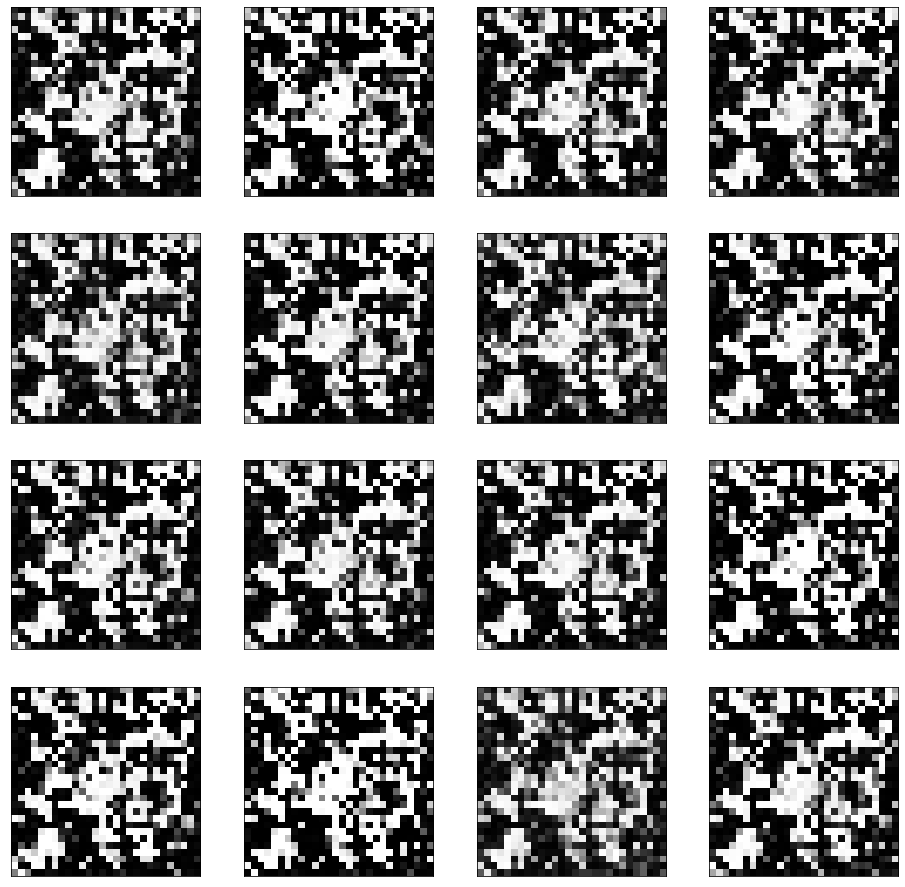

-------------------------------------------------------------------
[epoch 34], [training time 7.11]
-------------------------------------------------------------------


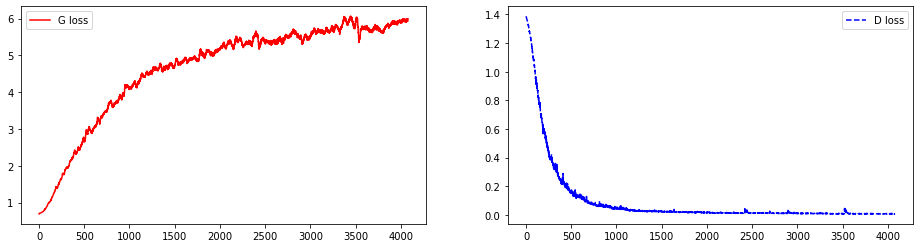

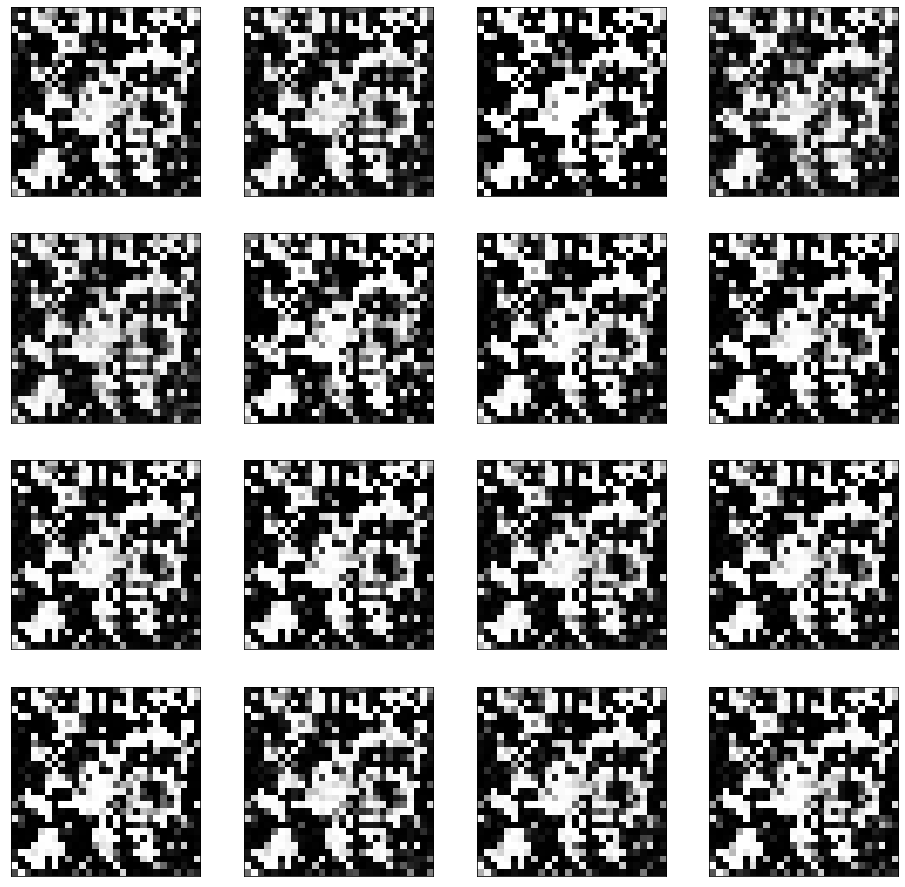

-------------------------------------------------------------------
[epoch 35], [training time 5.99]
-------------------------------------------------------------------


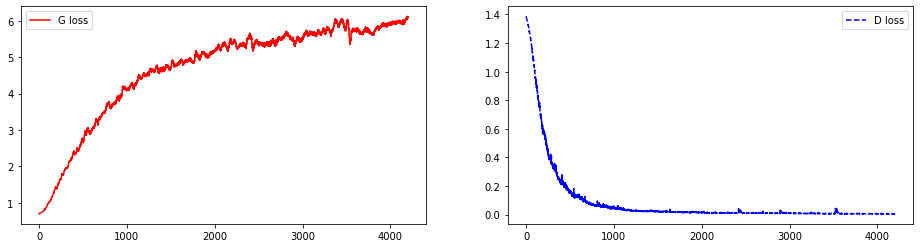

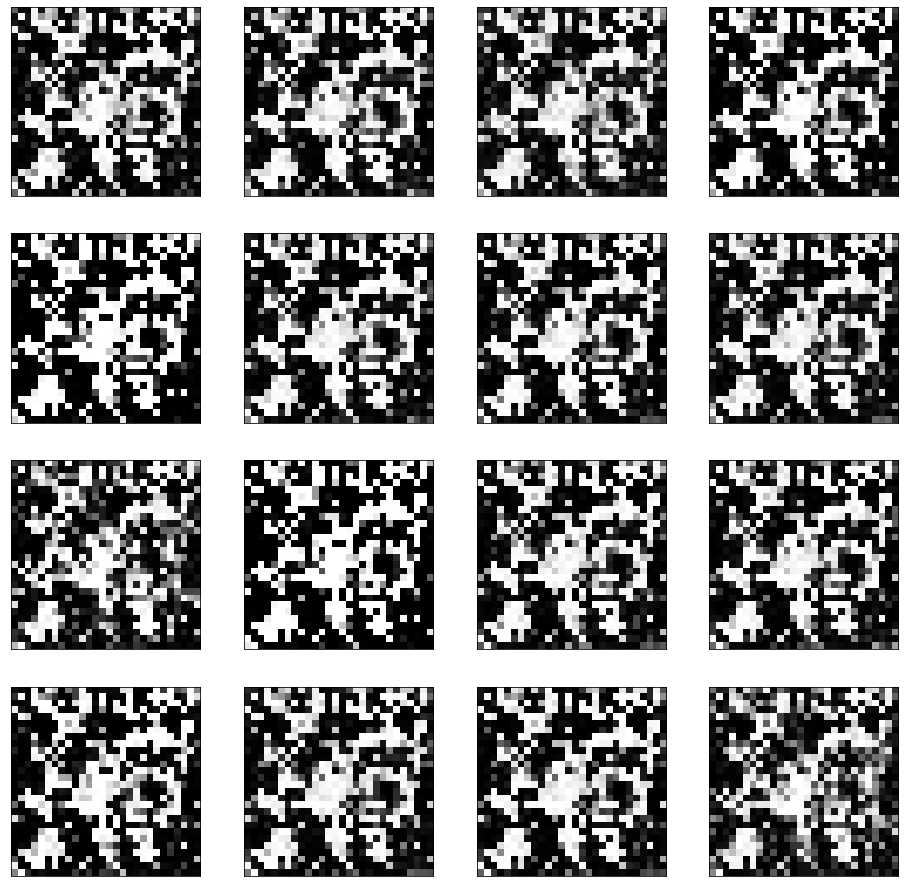

-------------------------------------------------------------------
[epoch 36], [training time 7.02]
-------------------------------------------------------------------


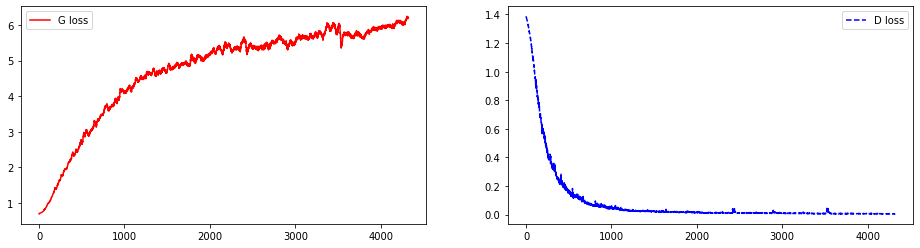

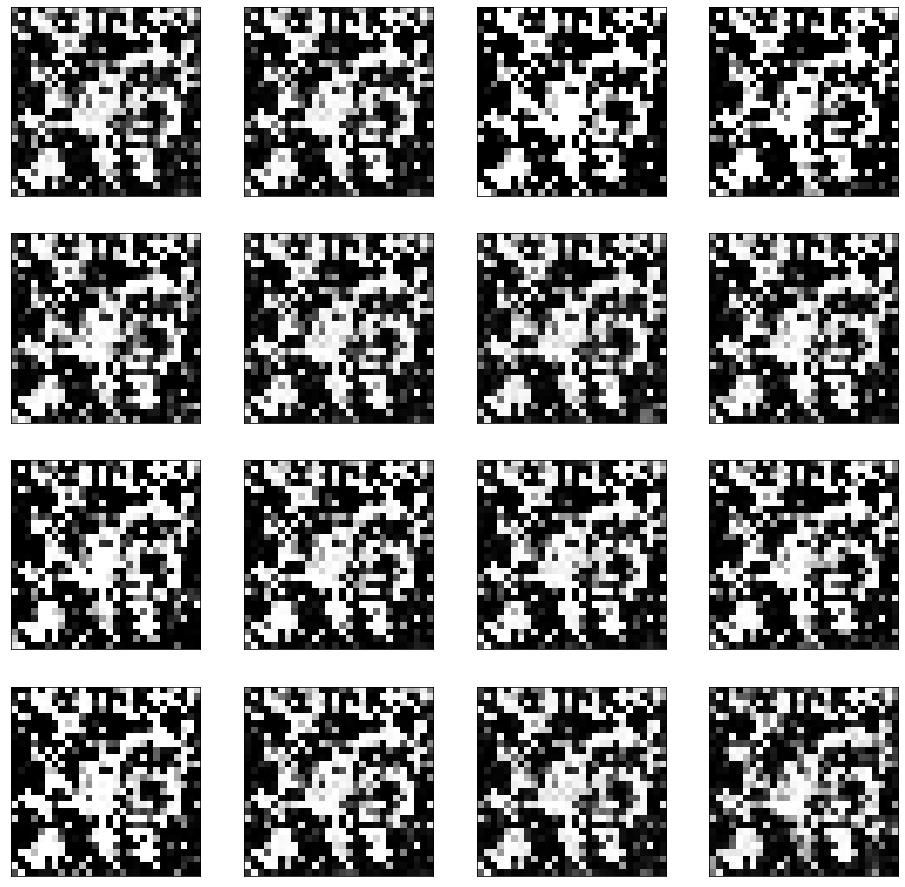

-------------------------------------------------------------------
[epoch 37], [training time 6.52]
-------------------------------------------------------------------


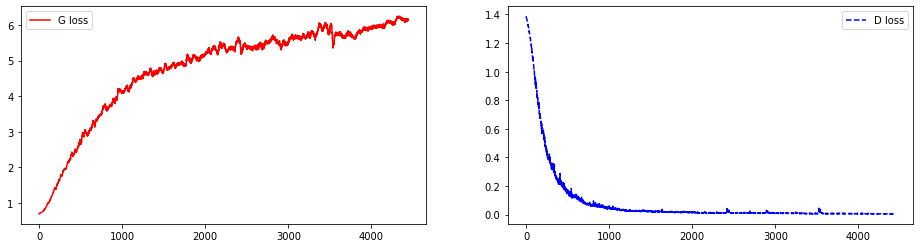

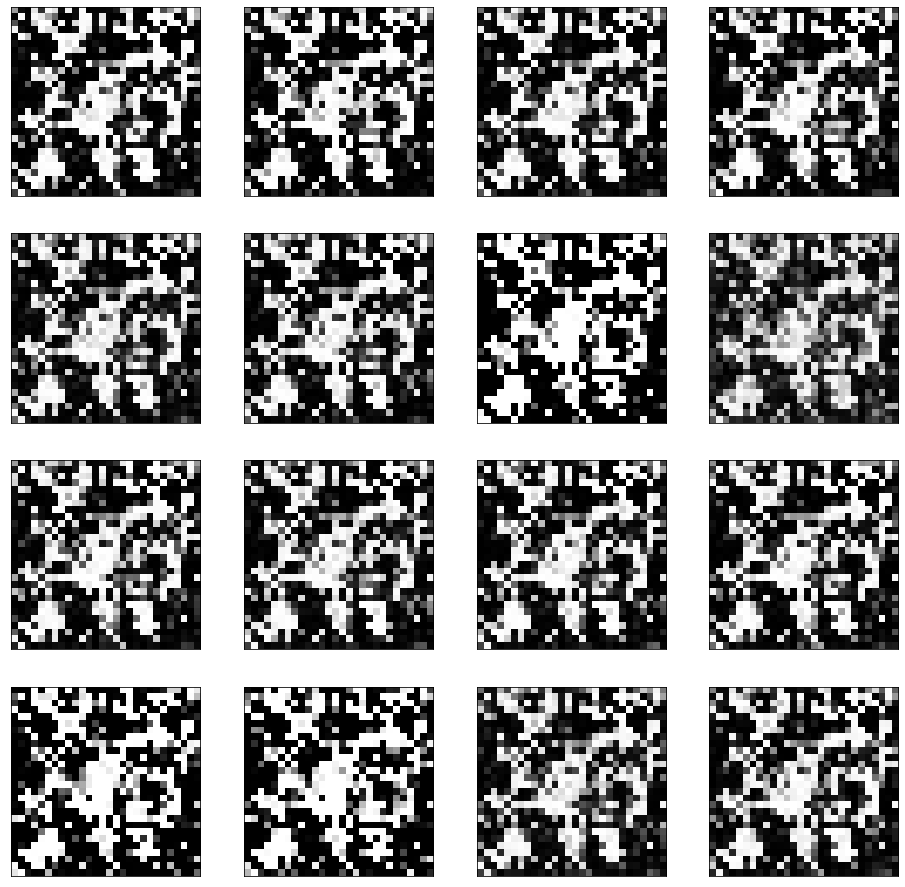

-------------------------------------------------------------------
[epoch 38], [training time 6.95]
-------------------------------------------------------------------


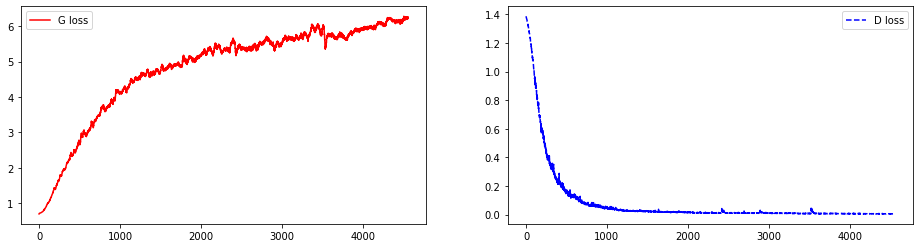

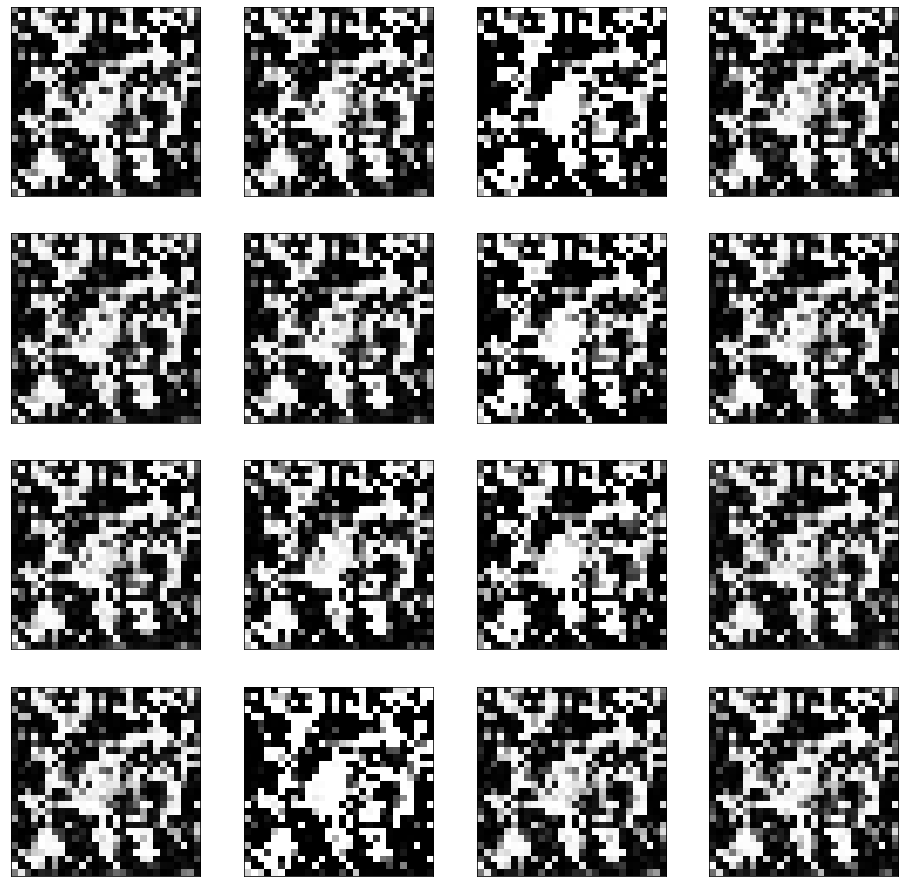

-------------------------------------------------------------------
[epoch 39], [training time 6.45]
-------------------------------------------------------------------


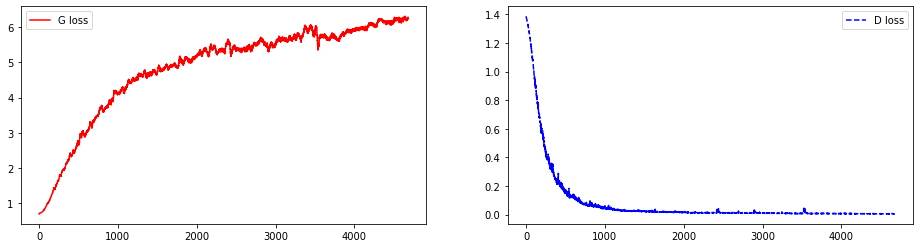

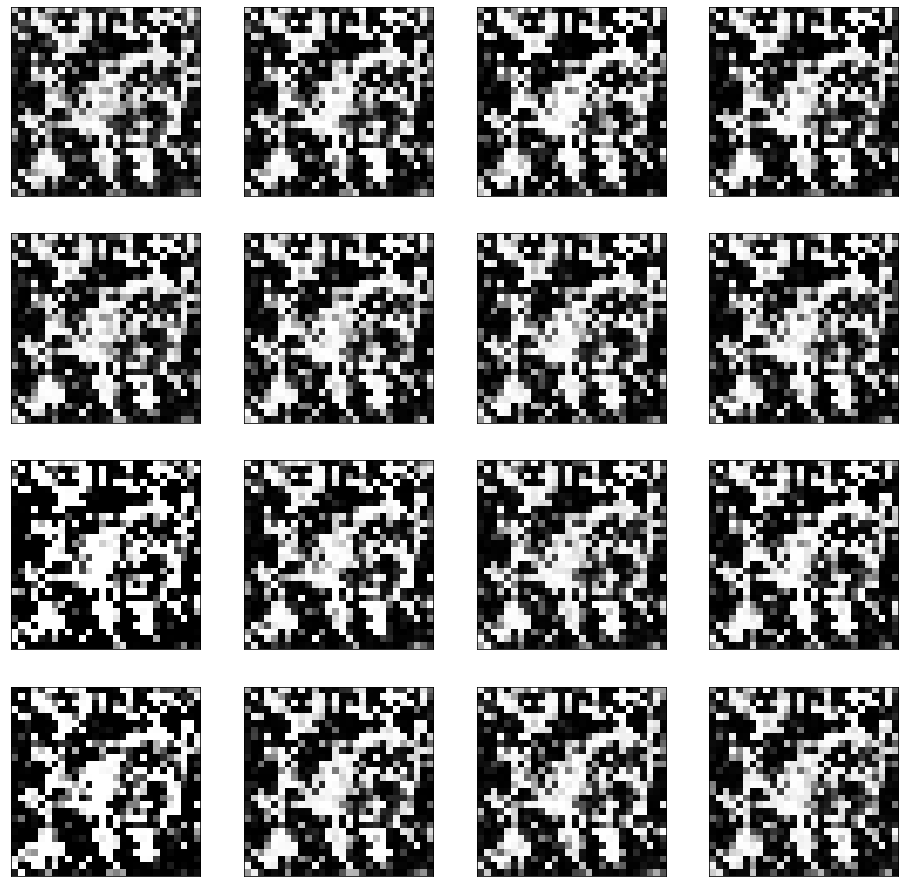

-------------------------------------------------------------------
[epoch 40], [training time 6.40]
-------------------------------------------------------------------


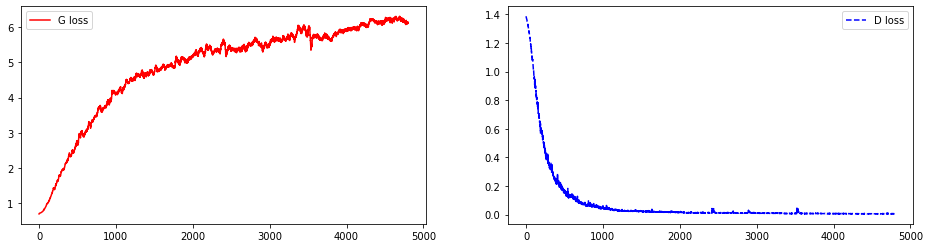

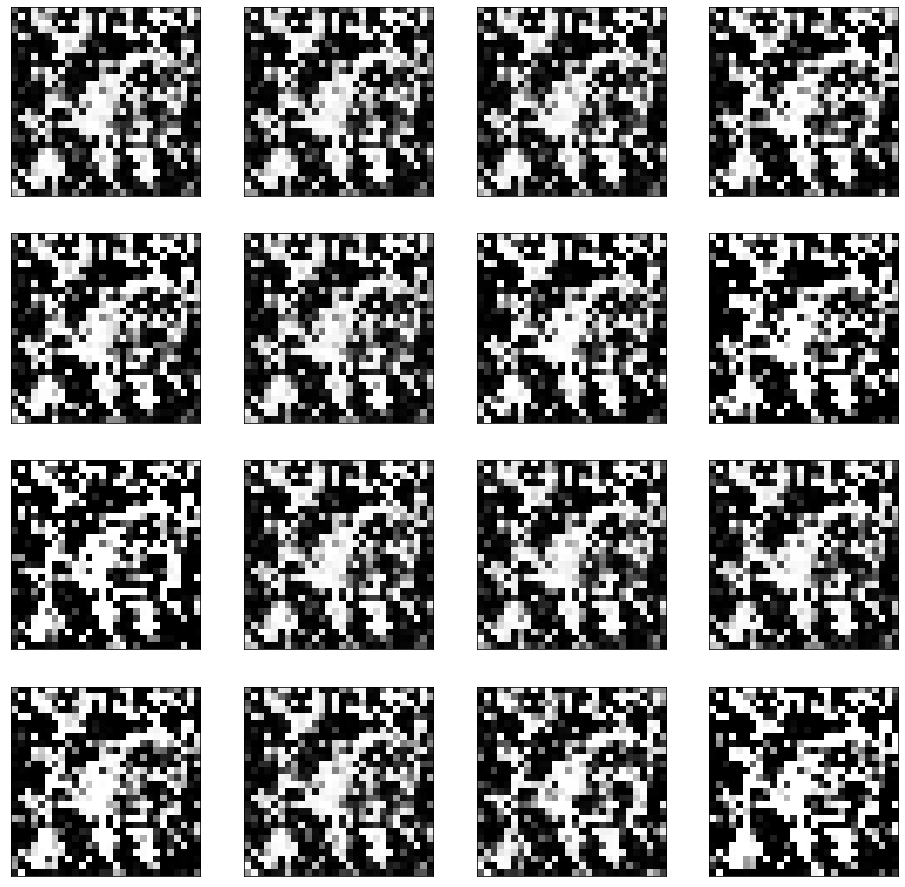

-------------------------------------------------------------------
[epoch 41], [training time 6.02]
-------------------------------------------------------------------


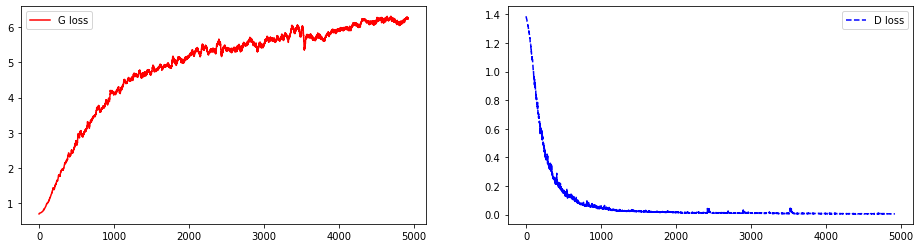

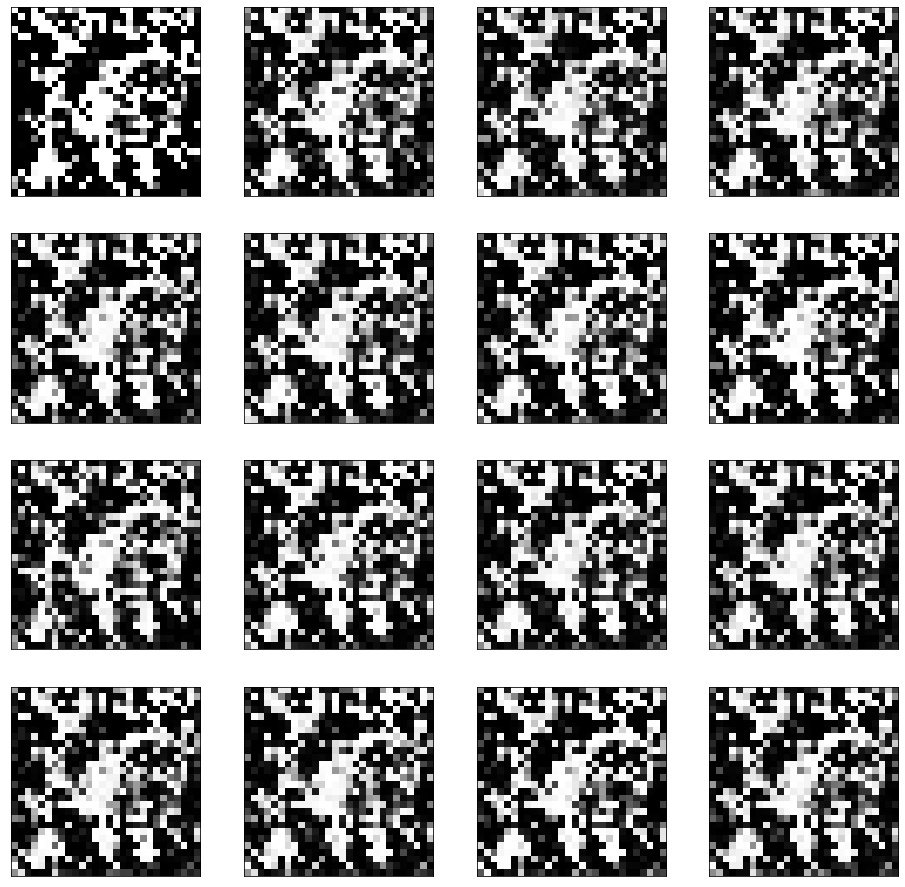

-------------------------------------------------------------------
[epoch 42], [training time 7.25]
-------------------------------------------------------------------


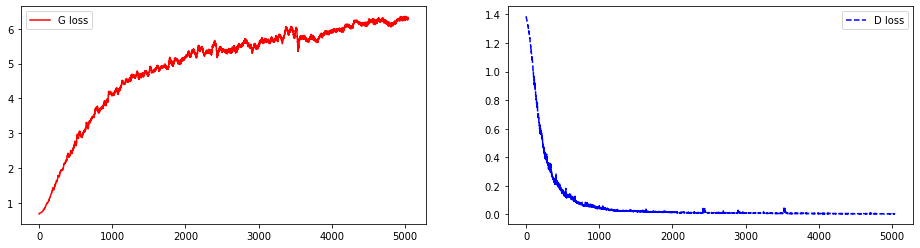

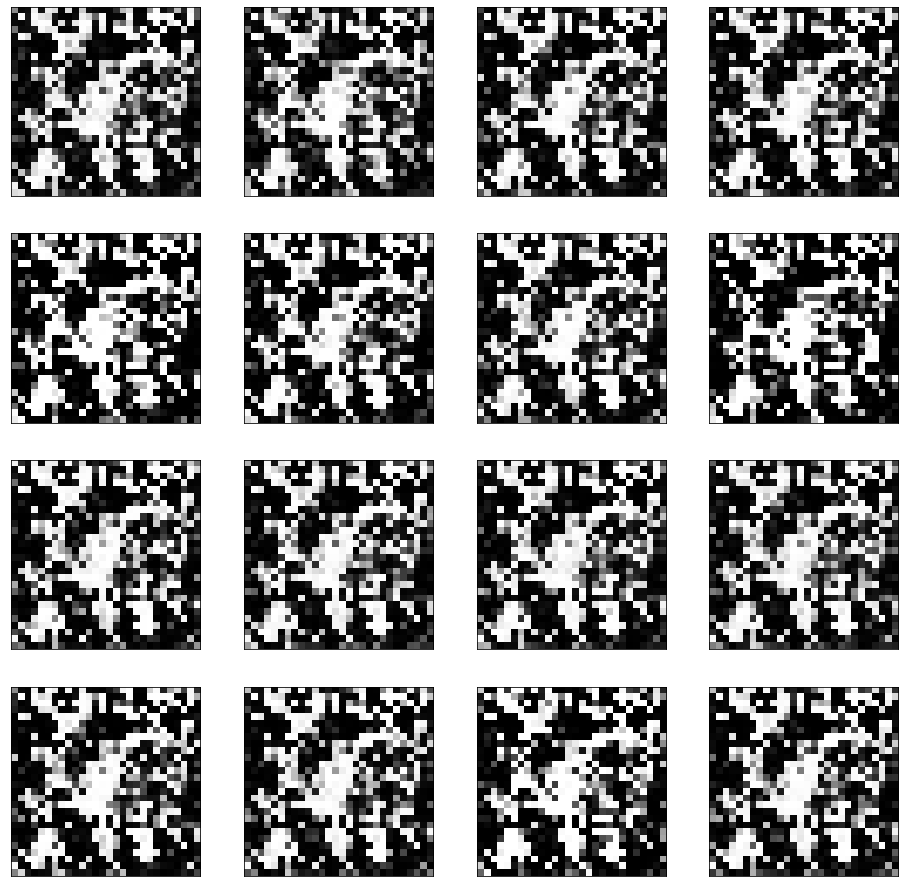

-------------------------------------------------------------------
[epoch 43], [training time 6.13]
-------------------------------------------------------------------


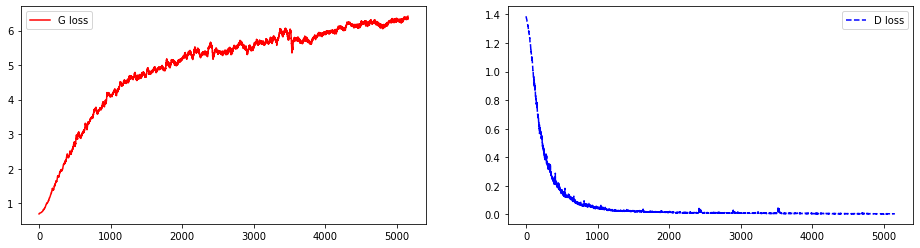

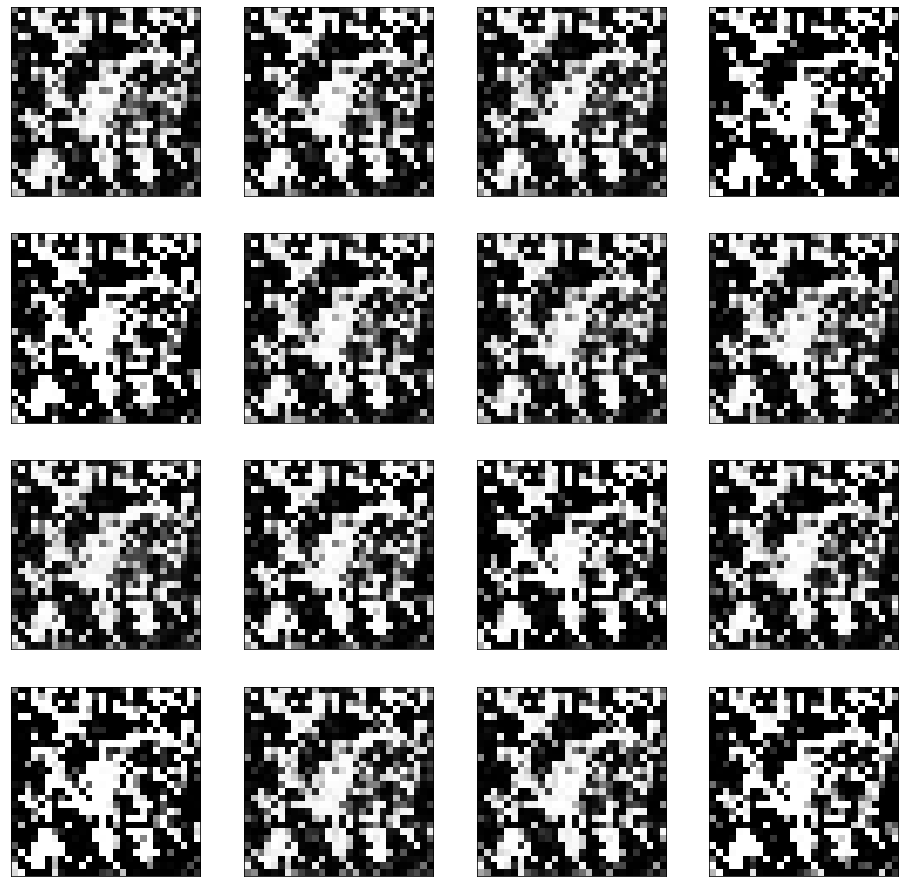

-------------------------------------------------------------------
[epoch 44], [training time 7.13]
-------------------------------------------------------------------


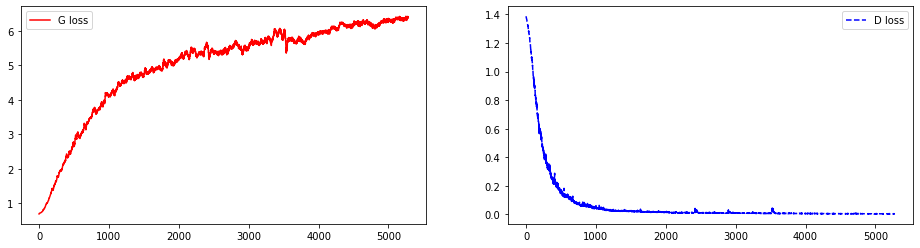

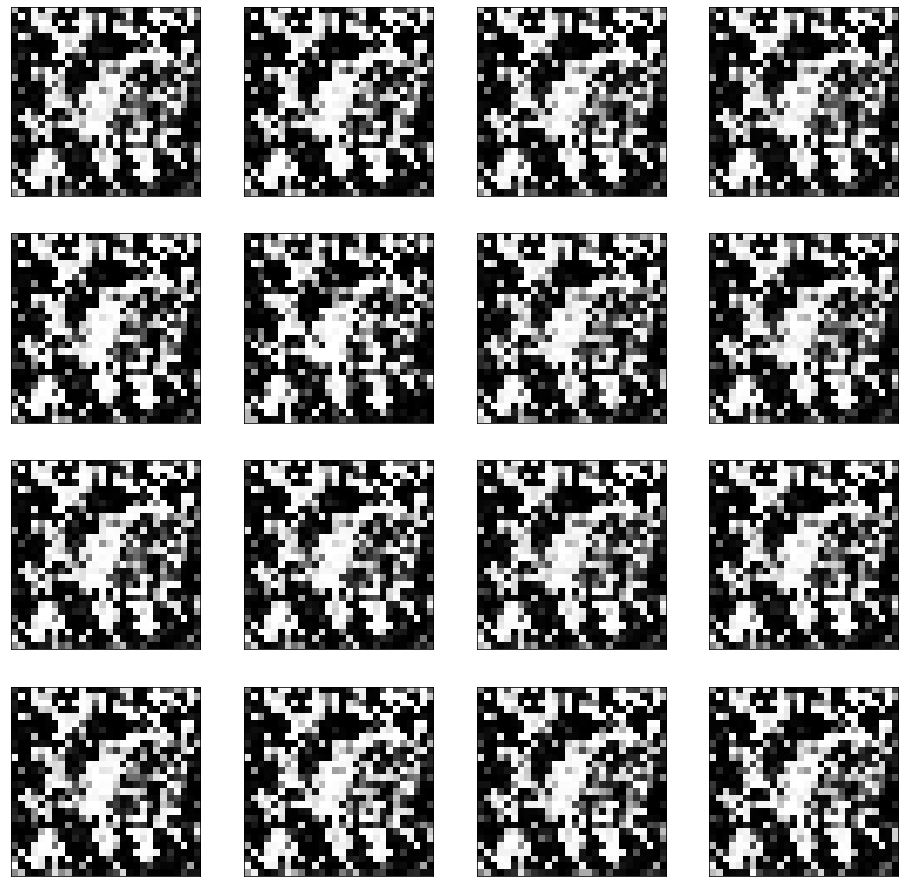

-------------------------------------------------------------------
[epoch 45], [training time 6.22]
-------------------------------------------------------------------


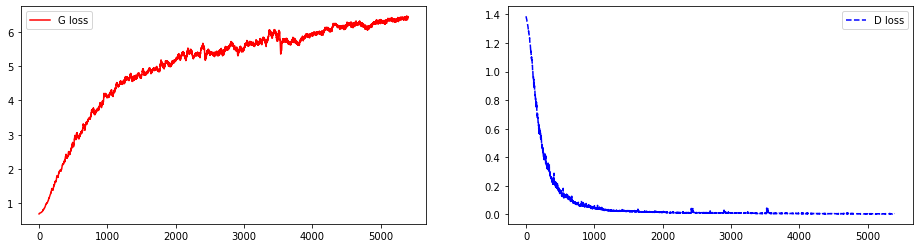

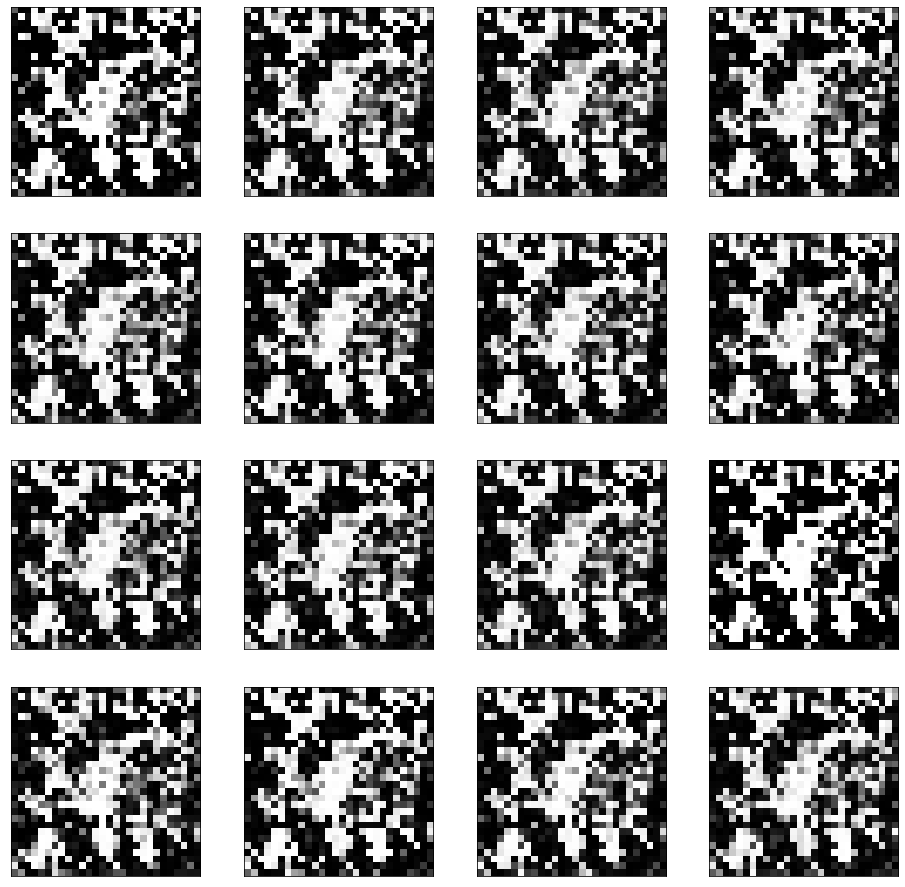

-------------------------------------------------------------------
[epoch 46], [training time 6.72]
-------------------------------------------------------------------


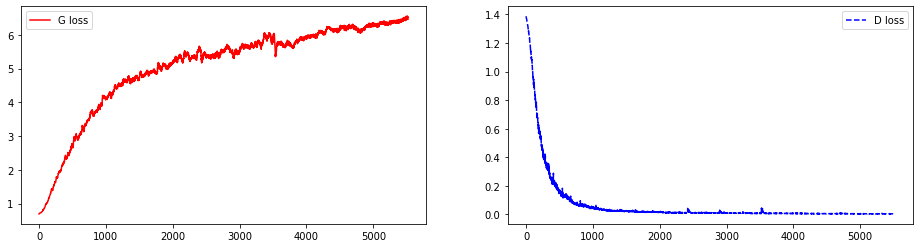

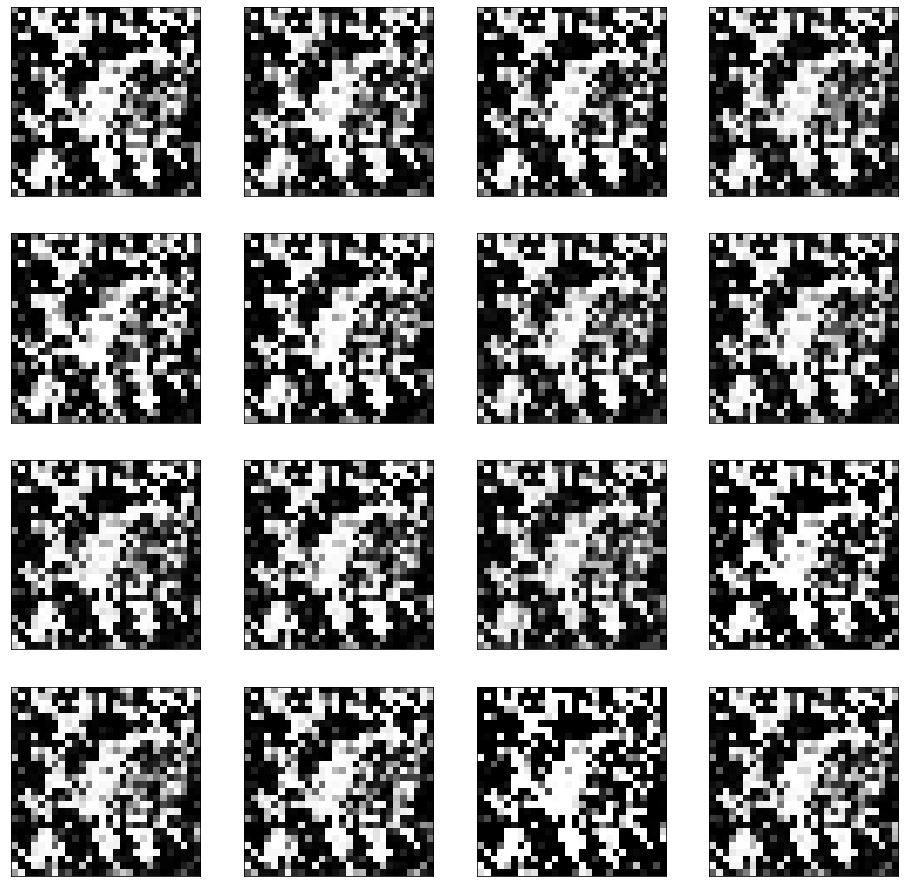

-------------------------------------------------------------------
[epoch 47], [training time 6.36]
-------------------------------------------------------------------


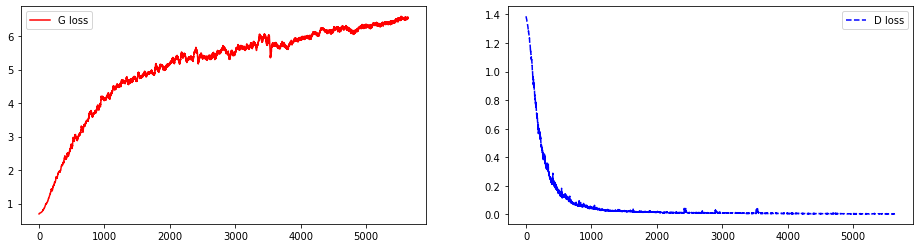

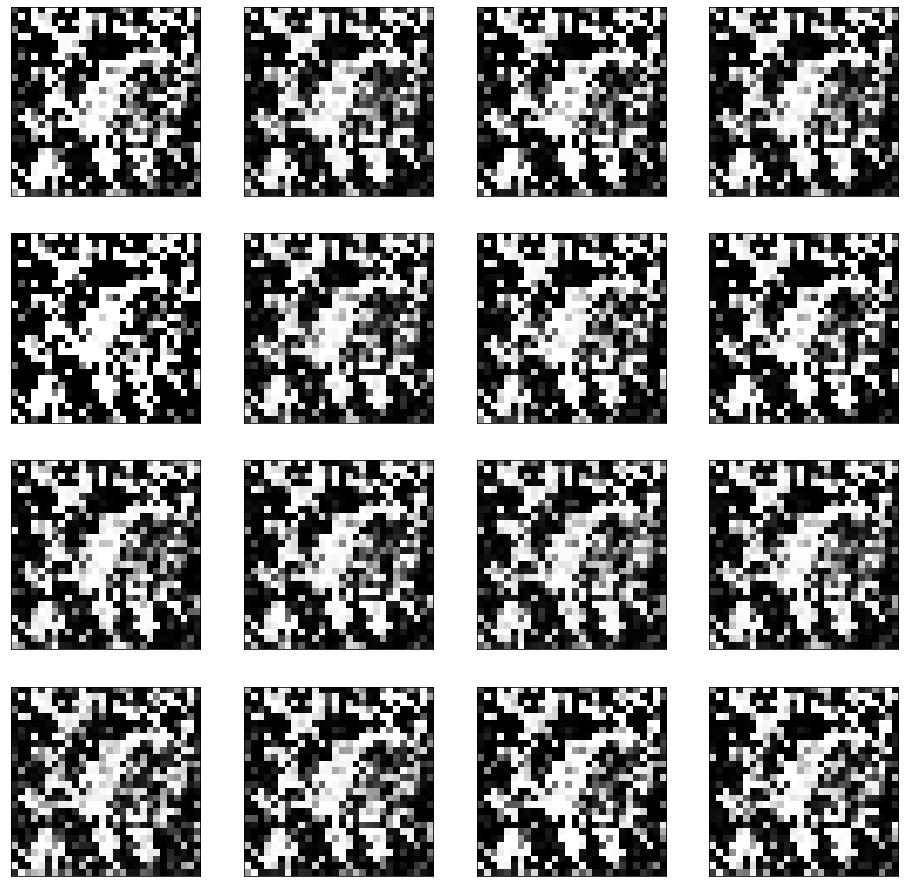

-------------------------------------------------------------------
[epoch 48], [training time 7.18]
-------------------------------------------------------------------


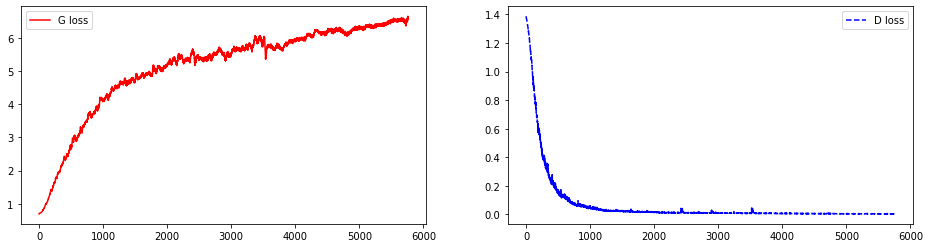

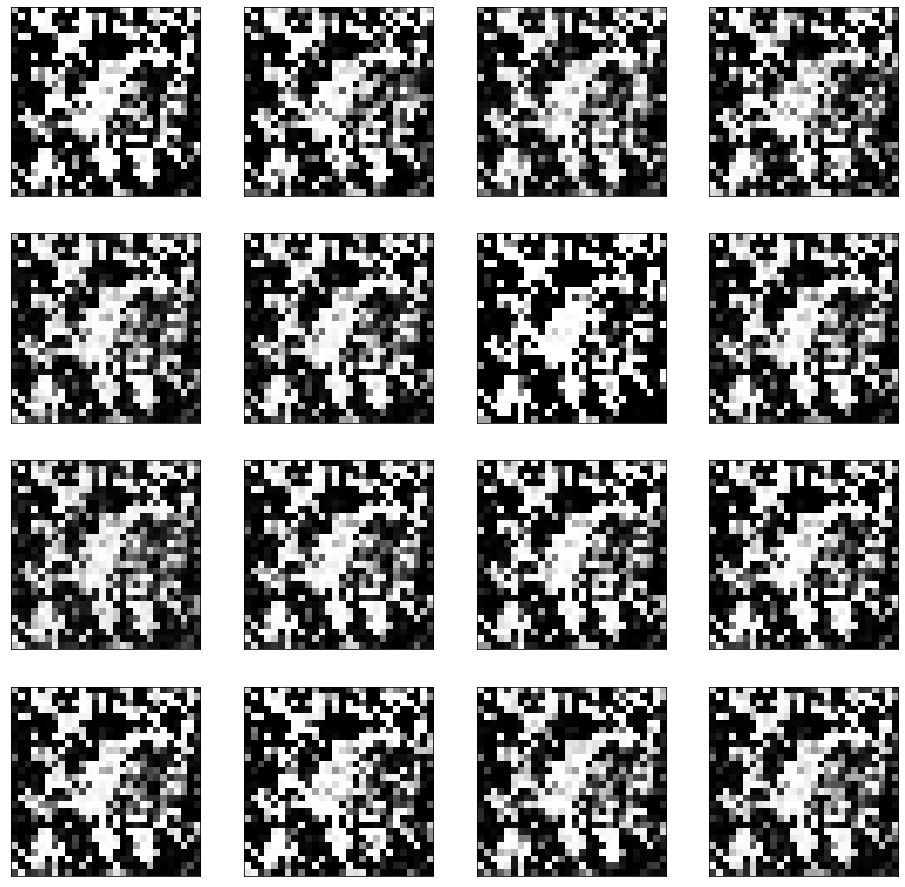

-------------------------------------------------------------------
[epoch 49], [training time 6.31]
-------------------------------------------------------------------


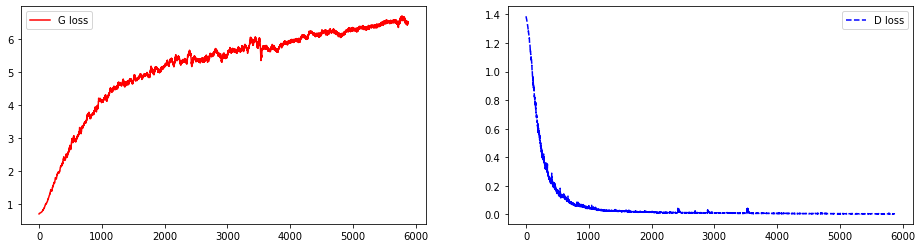

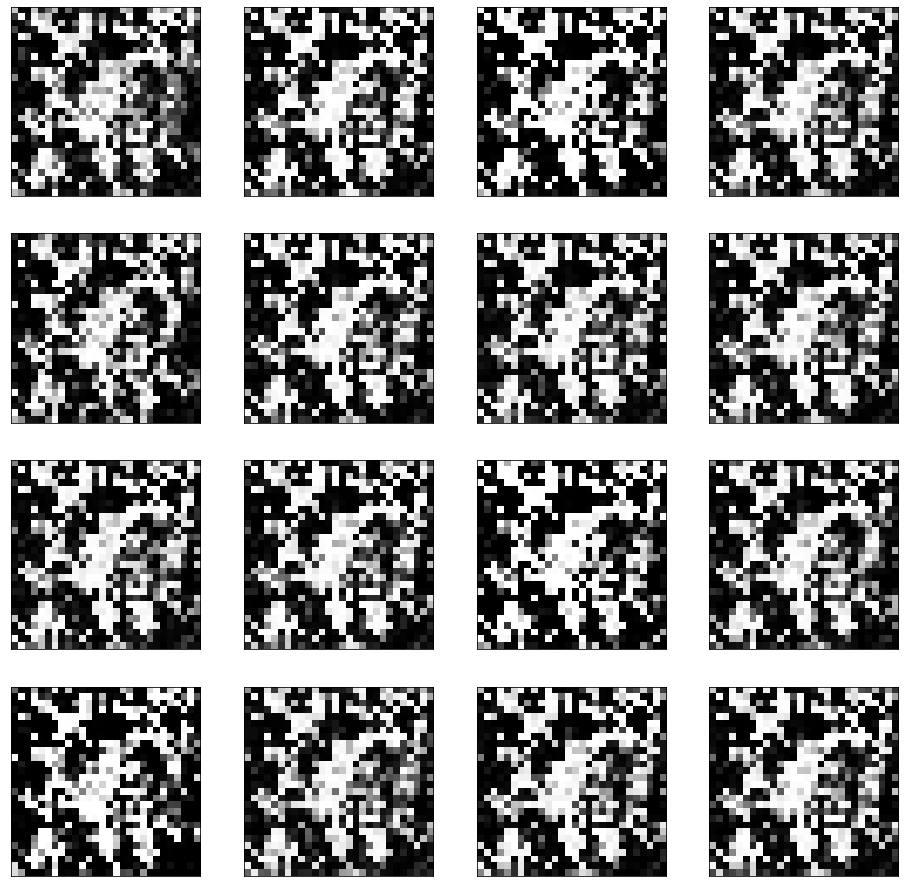

-------------------------------------------------------------------
[epoch 50], [training time 6.84]
-------------------------------------------------------------------


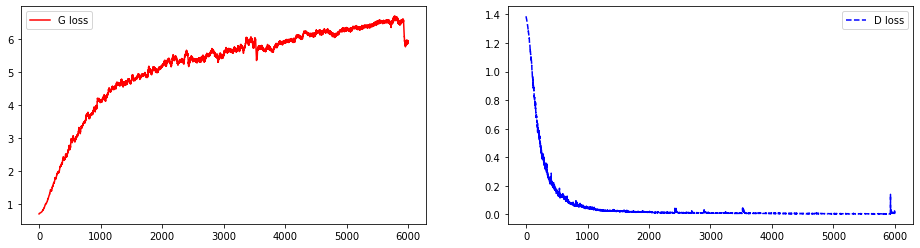

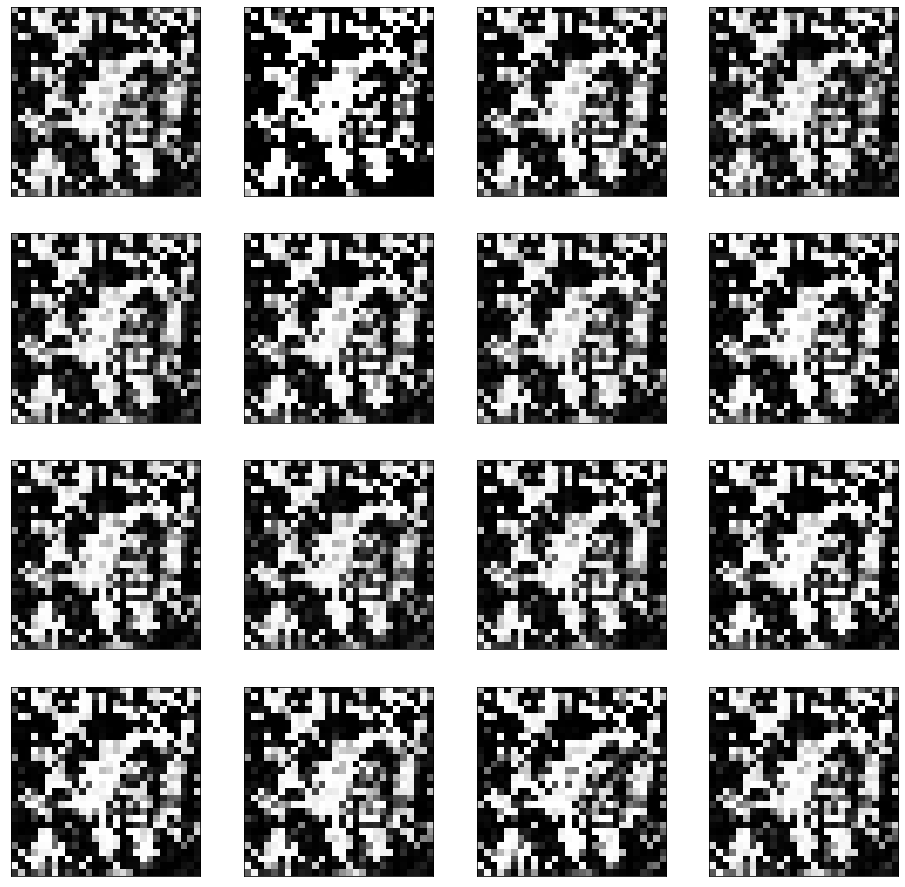

In [ ]:
# Lists for losses.
train_loss_G = []
train_loss_D = []

# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train_loss_G, train_loss_D = train(train_loader,
                                       net_G, net_D,
                                       criterion,
                                       opt_G, opt_D,
                                       epoch,
                                       train_loss_G, train_loss_D)
    
    # Taking step on scheduler.
    scheduler_G.step()
    scheduler_D.step()

    # Testing function for sample generation.
    test(net_G, criterion, epoch)